In [175]:
library(pheatmap)
library(dplyr)
library(tidyverse)
library(msigdbr)
library(GSVA) 
library(matrixStats)
library(reshape2)
library(ggplot2)

# Region bulk RNA

In [2]:
df = read.csv('/home/zhaoyp/0.CRLM_ST/res/TumorBorderRegion/stat.csv',row.names=1)

In [3]:

anno = data.frame(df['sample'])
colnames(anno) <- 'group'
anno$sample = sapply( anno[['group']], function(x) strsplit(x,'-')[[1]][1] )
anno$region = sapply( anno[['group']], function(x) strsplit(x,'-')[[1]][2] )
anno$patient = sapply( anno[['sample']], function(x) strsplit(x,'_')[[1]][1] )
anno$tissue = sapply( anno[['sample']], function(x) strsplit(x,'_')[[1]][2] )
anno$group = sapply(anno$group, function(x) strsplit(x,'_')[[1]][2])
anno <- anno[,c('region','patient','tissue')]

In [33]:
ann_colors = list(
   region= c(Border= '#1f77b4', Normal='#2ca02c', Tumor='#ff7f0e' ),
   tissue = c(LM = "#D46363", CC = "#FDBAA7")
)
bk <- c(seq(-1,-0.1,by=0.01),seq(0,1,by=0.01))


In [34]:
df = df[,1:(dim(df)[2]-1)]

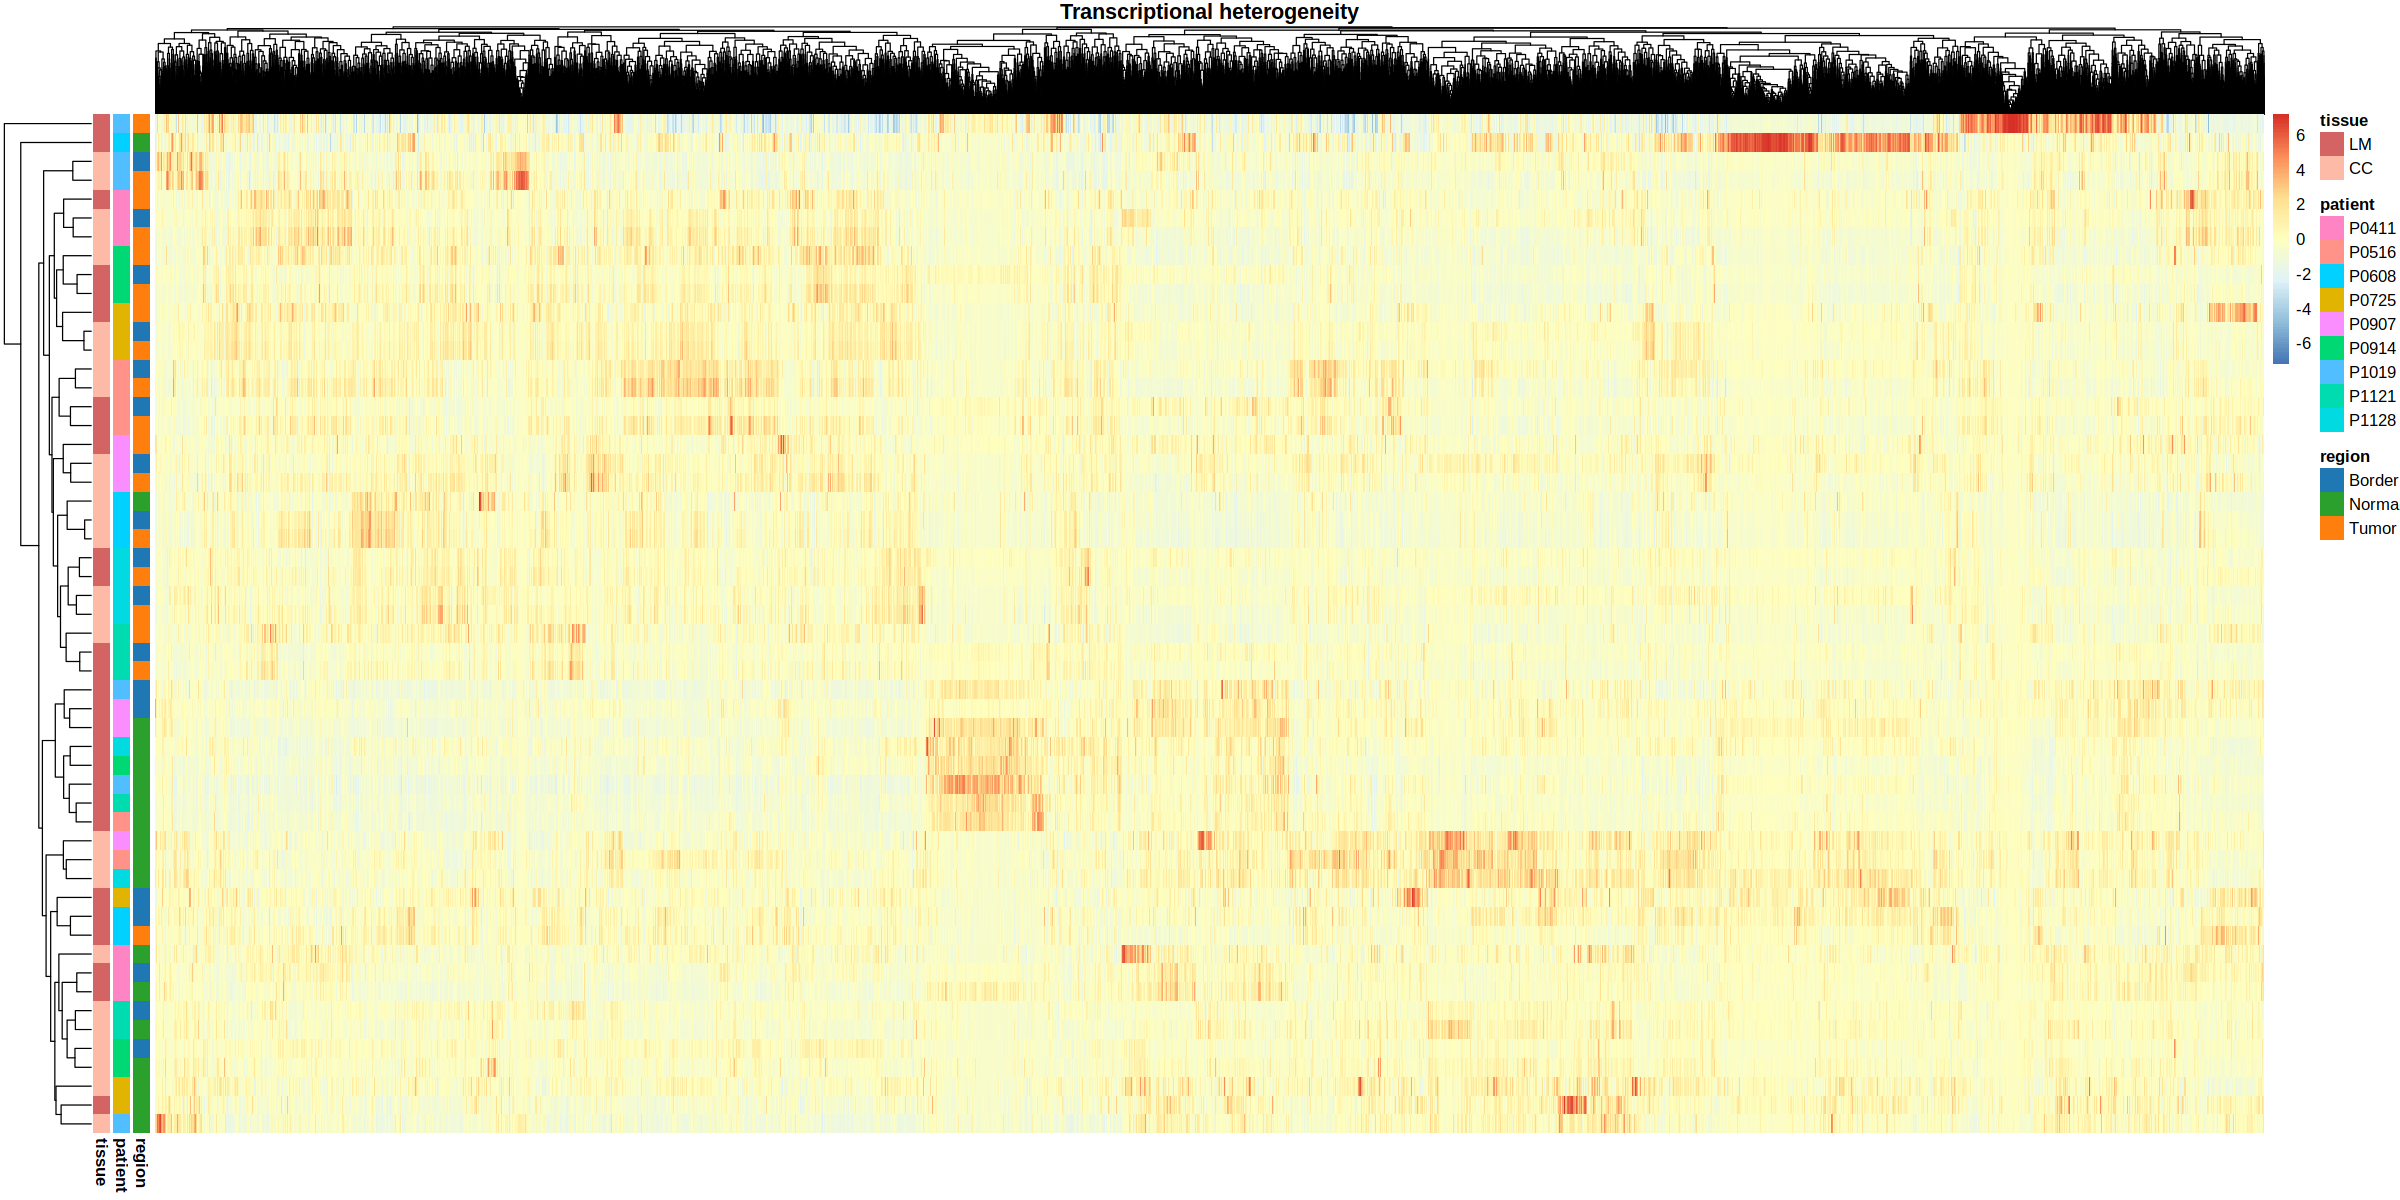

In [35]:
options(repr.plot.width=20,repr.plot.height=10)
pheatmap(df, show_rownames = FALSE, scale='column', show_colnames = FALSE, annotation_row=anno, annotation_colors=ann_colors,
         main='Transcriptional heterogeneity')  # scale='row',


In [44]:
df0 = t(scale(df))
cr = cor(df0)


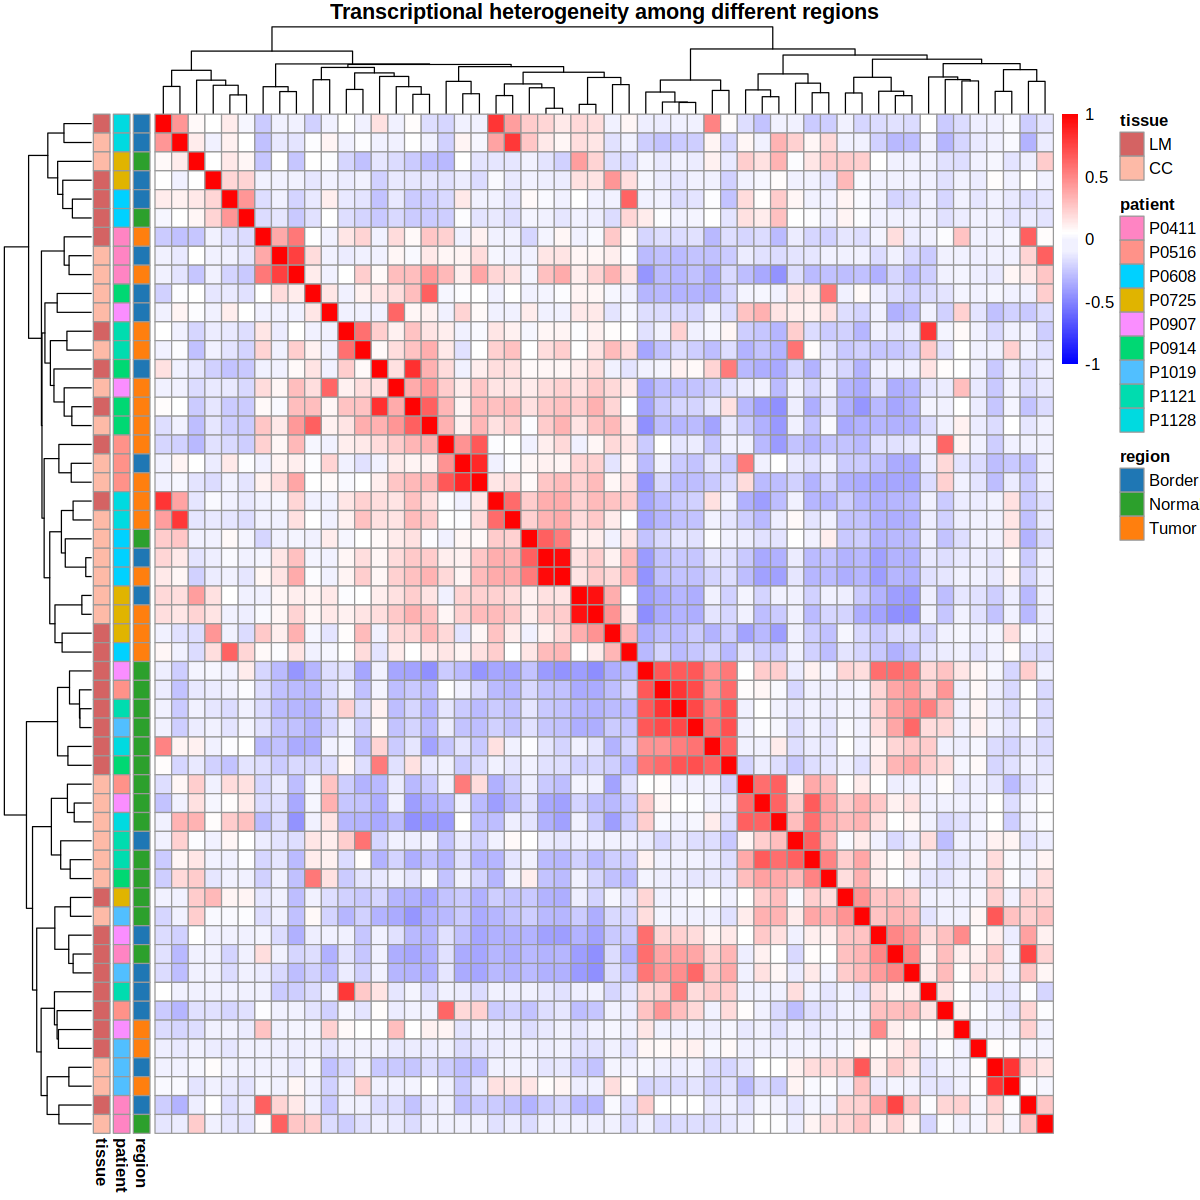

In [46]:
options(repr.plot.width=10,repr.plot.height=10)
pheatmap(cr, show_rownames = FALSE,  show_colnames = FALSE, annotation_row=anno,  annotation_colors=ann_colors,breaks=bk,
         color = c(colorRampPalette(colors = c("blue","white"))(length(bk)/2), colorRampPalette(colors = c("white","red"))(length(bk)/2)),
         main='Transcriptional heterogeneity among different regions')  # scale='row', scale='column'



In [38]:
index = (anno['region']=='Border')
anno_1 = anno[index,]
df1 = df[index,] 


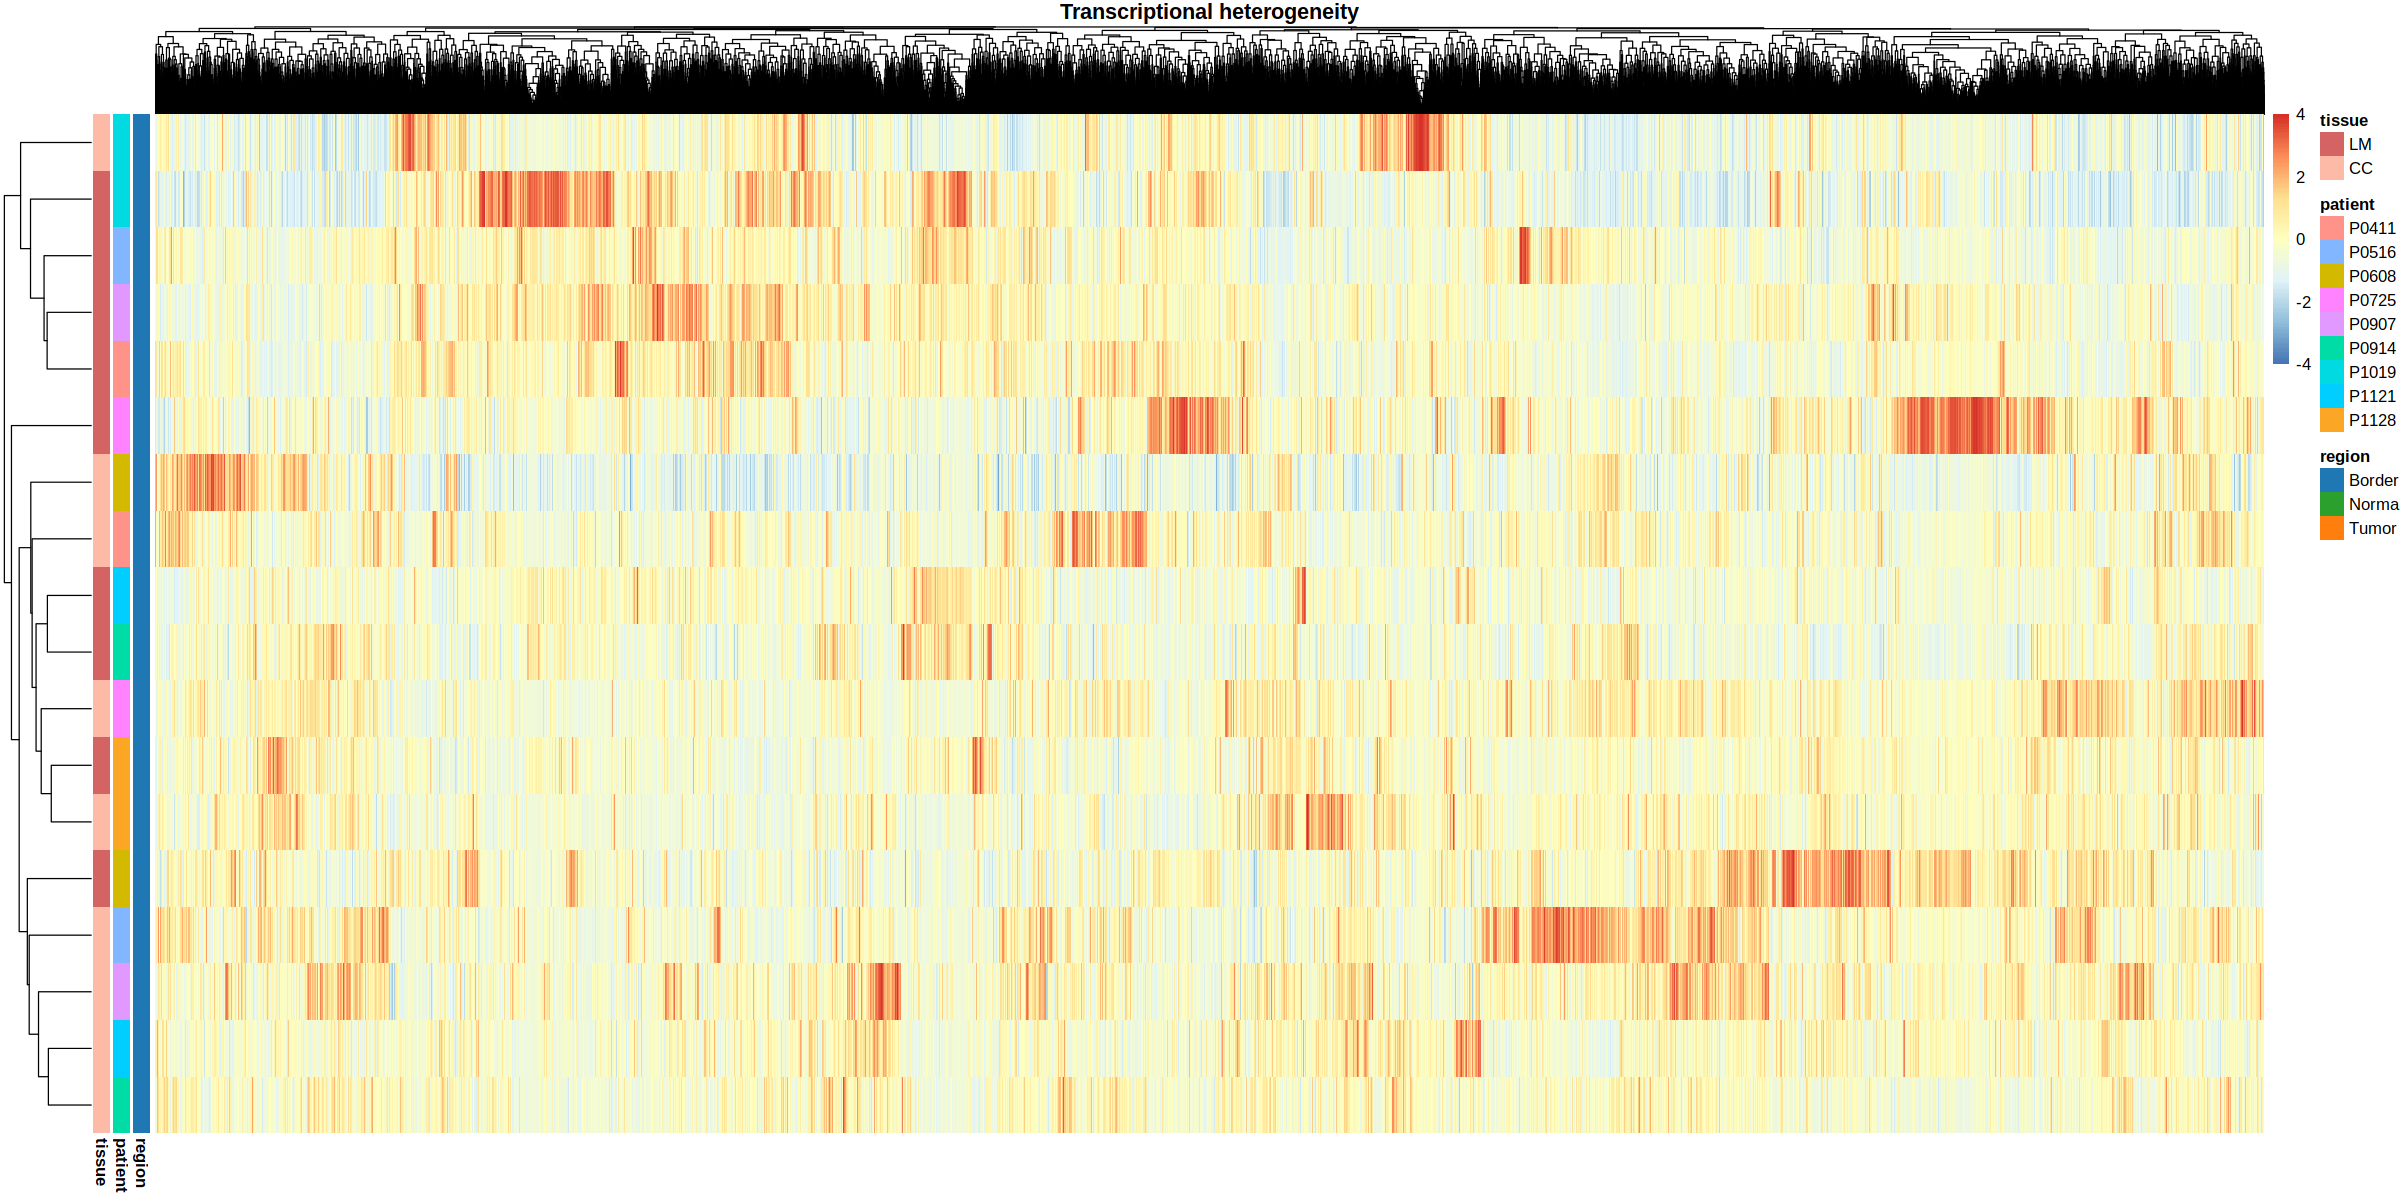

In [39]:
options(repr.plot.width=20,repr.plot.height=10)
pheatmap(df1, show_rownames = FALSE, scale='column', show_colnames = FALSE, annotation_row=anno_1,  annotation_colors=ann_colors,
         main='Transcriptional heterogeneity')  # scale='row',


In [48]:
df11 = t(scale(df1))
cr = cor(df11)

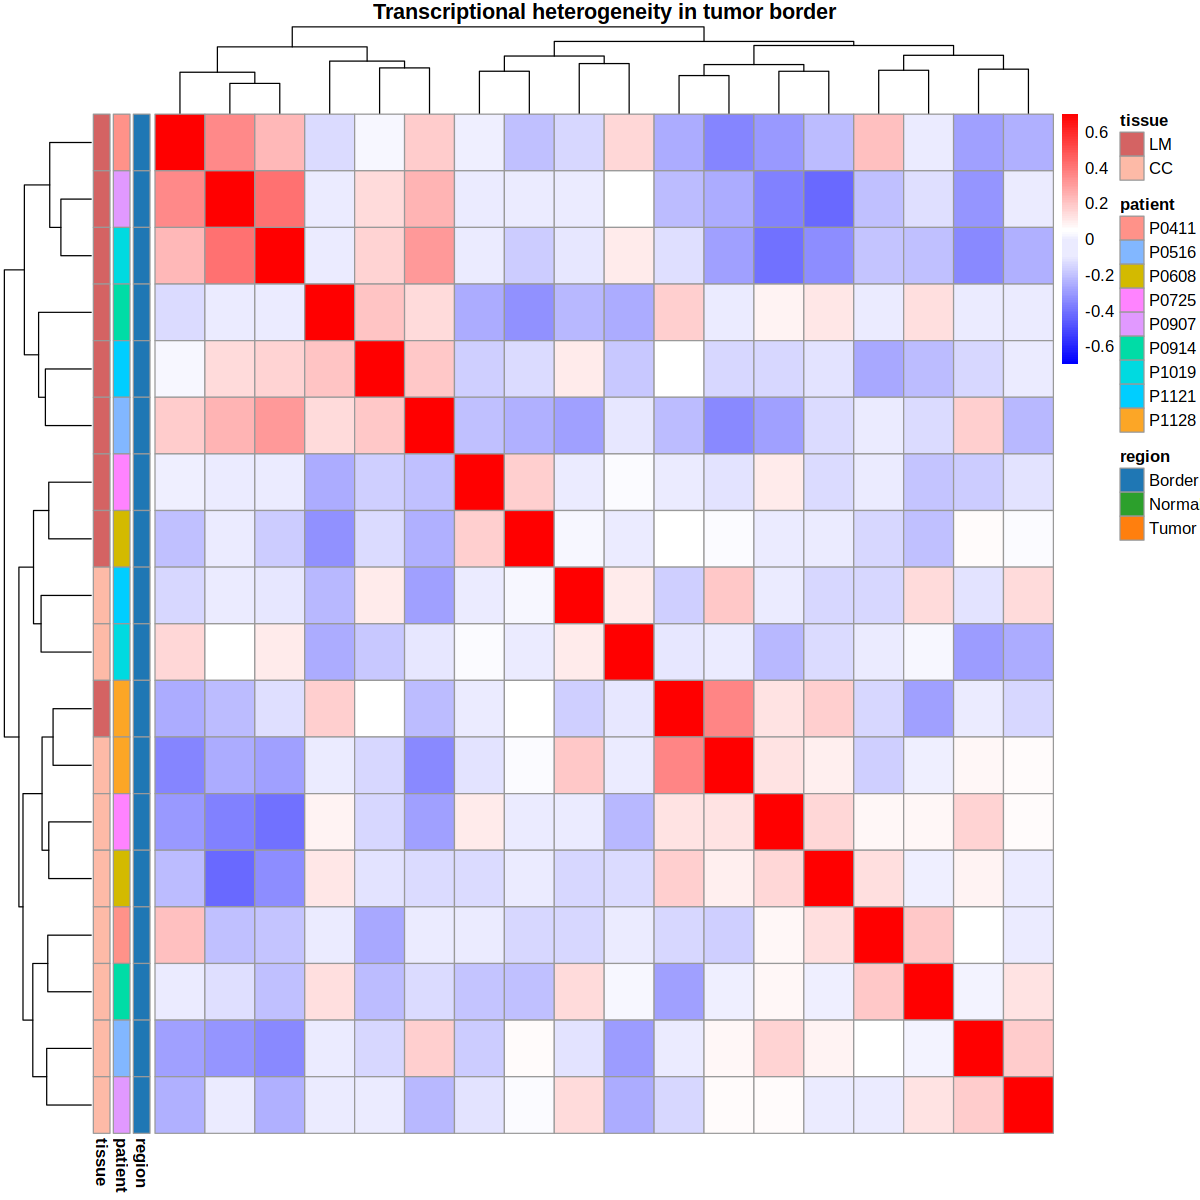

In [106]:
options(repr.plot.width=10,repr.plot.height=10)
bk <- c(seq(-0.7,-0.1,by=0.01),seq(0,0.7,by=0.01))
pheatmap(cr, show_rownames = FALSE,  show_colnames = FALSE, annotation_row=anno, vmin=-0.5,breaks=bk, annotation_colors=ann_colors,
         color = c(colorRampPalette(colors = c("blue","white"))(length(bk)/2), colorRampPalette(colors = c("white","red"))(length(bk)/2)),
         main='Transcriptional heterogeneity in tumor border')  # scale='row', scale='column'


### GSVA

In [198]:
df = read.csv('/home/zhaoyp/0.CRLM_ST/res/TumorBorderRegion/stat.csv',row.names=1)

In [199]:

anno = data.frame(df['sample'])
colnames(anno) <- 'group'
anno$sample = sapply( anno[['group']], function(x) strsplit(x,'-')[[1]][1] )
anno$region = sapply( anno[['group']], function(x) strsplit(x,'-')[[1]][2] )
anno$patient = sapply( anno[['sample']], function(x) strsplit(x,'_')[[1]][1] )
anno$tissue = sapply( anno[['sample']], function(x) strsplit(x,'_')[[1]][2] )
anno$group = sapply(anno$group, function(x) strsplit(x,'_')[[1]][2])
group <- anno$group
anno <- anno[,c('region','patient','tissue')] 
# anno <- anno[,c('group','patient')]


In [200]:
# rownames(df) <- anno$group
df = df[,1:(dim(df)[2]-1)]

In [201]:
GO_bp = msigdbr(species = "Homo sapiens",
                      ,category = "H") %>% 
                       # filter(grepl('MACRO',gs_name))  %>%
                      dplyr::select(gs_name,gene_symbol)#这里可以选择gene symbol，也可以选择ID，根据自己数据需求来，主要为了方便
GO_bp_Set = GO_bp %>% split(x = .$gene_symbol, f = .$gs_name)#后续gsva要求是list，所以将他转化为list


In [202]:

mat = log(as.matrix(t(df)))
# rownames(mat) = rownames(df)
# colnames(mat) = colnames(df)


In [203]:
subset_gsva <- gsva(mat , 
                kcdf="Gaussian",
                gset.idx.list = GO_bp_Set,
                method='gsva') 


Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message in .filterFeatures(expr, method):
“10844 genes with constant expression values throuhgout the samples.”
Warning message in .filterFeatures(expr, method):
“Since argument method!="ssgsea", genes with constant expression values are discarded.”


Estimating GSVA scores for 50 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



null device 
          1

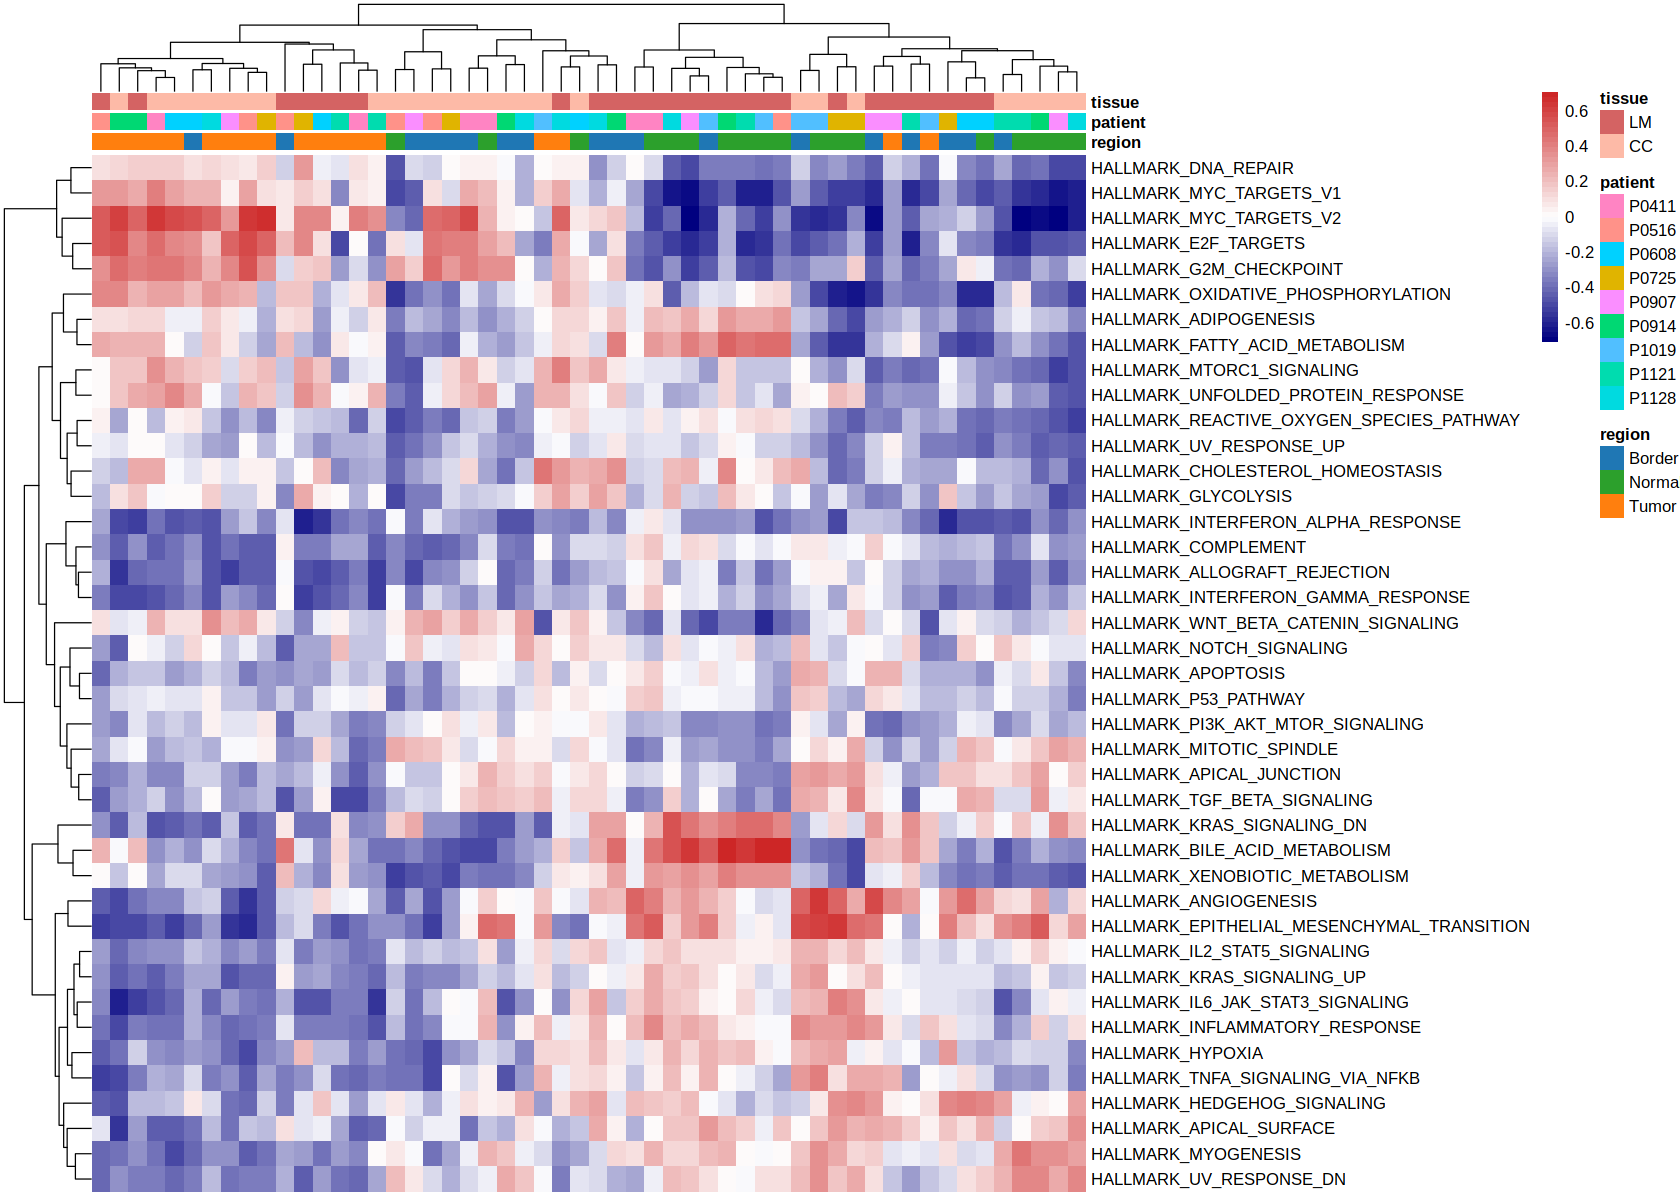

In [204]:
options(repr.plot.width=14,repr.plot.height=10)
# subset_gsva_p <- subset_gsva[which(apply(subset_gsva, 1, max) > 0.7),]

subset_gsva = subset_gsva[!(rownames(subset_gsva) %in% c('HALLMARK_ANDROGEN_RESPONSE','HALLMARK_COAGULATION', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 
            'HALLMARK_ESTROGEN_RESPONSE_LATE','HALLMARK_HEME_METABOLISM', 'HALLMARK_PANCREAS_BETA_CELLS', 'HALLMARK_PEROXISOME', 'HALLMARK_PROTEIN_SECRETION', 
            'HALLMARK_SPERMATOGENESIS')),]

ann_colors = list(
   region= c(Border= '#1f77b4', Normal='#2ca02c', Tumor='#ff7f0e' ),
   tissue = c(LM = "#D46363", CC = "#FDBAA7")
)

pheatmap(subset_gsva, show_colnames=F, show_rownames=T, fontsize_row = 10, fontsize_col = 10, cluster_col=T, annotation_col=anno,
         annotation_colors=ann_colors,
         color=colorRampPalette(c('navy','white','firebrick3'))(50)) #  scale='row',
dev.off() 


In [244]:
subset_gsva_p <- as.data.frame(t(subset_gsva))
subset_gsva_p$group <- c(group)
subset_gsva_p <- melt(subset_gsva_p, id.vars='group',variable.name='hallmark')
subset_gsva_p$hallmark <- sapply(subset_gsva_p[['hallmark']], function(x) substring(as.character(x),10,nchar(as.character(x)) ) )


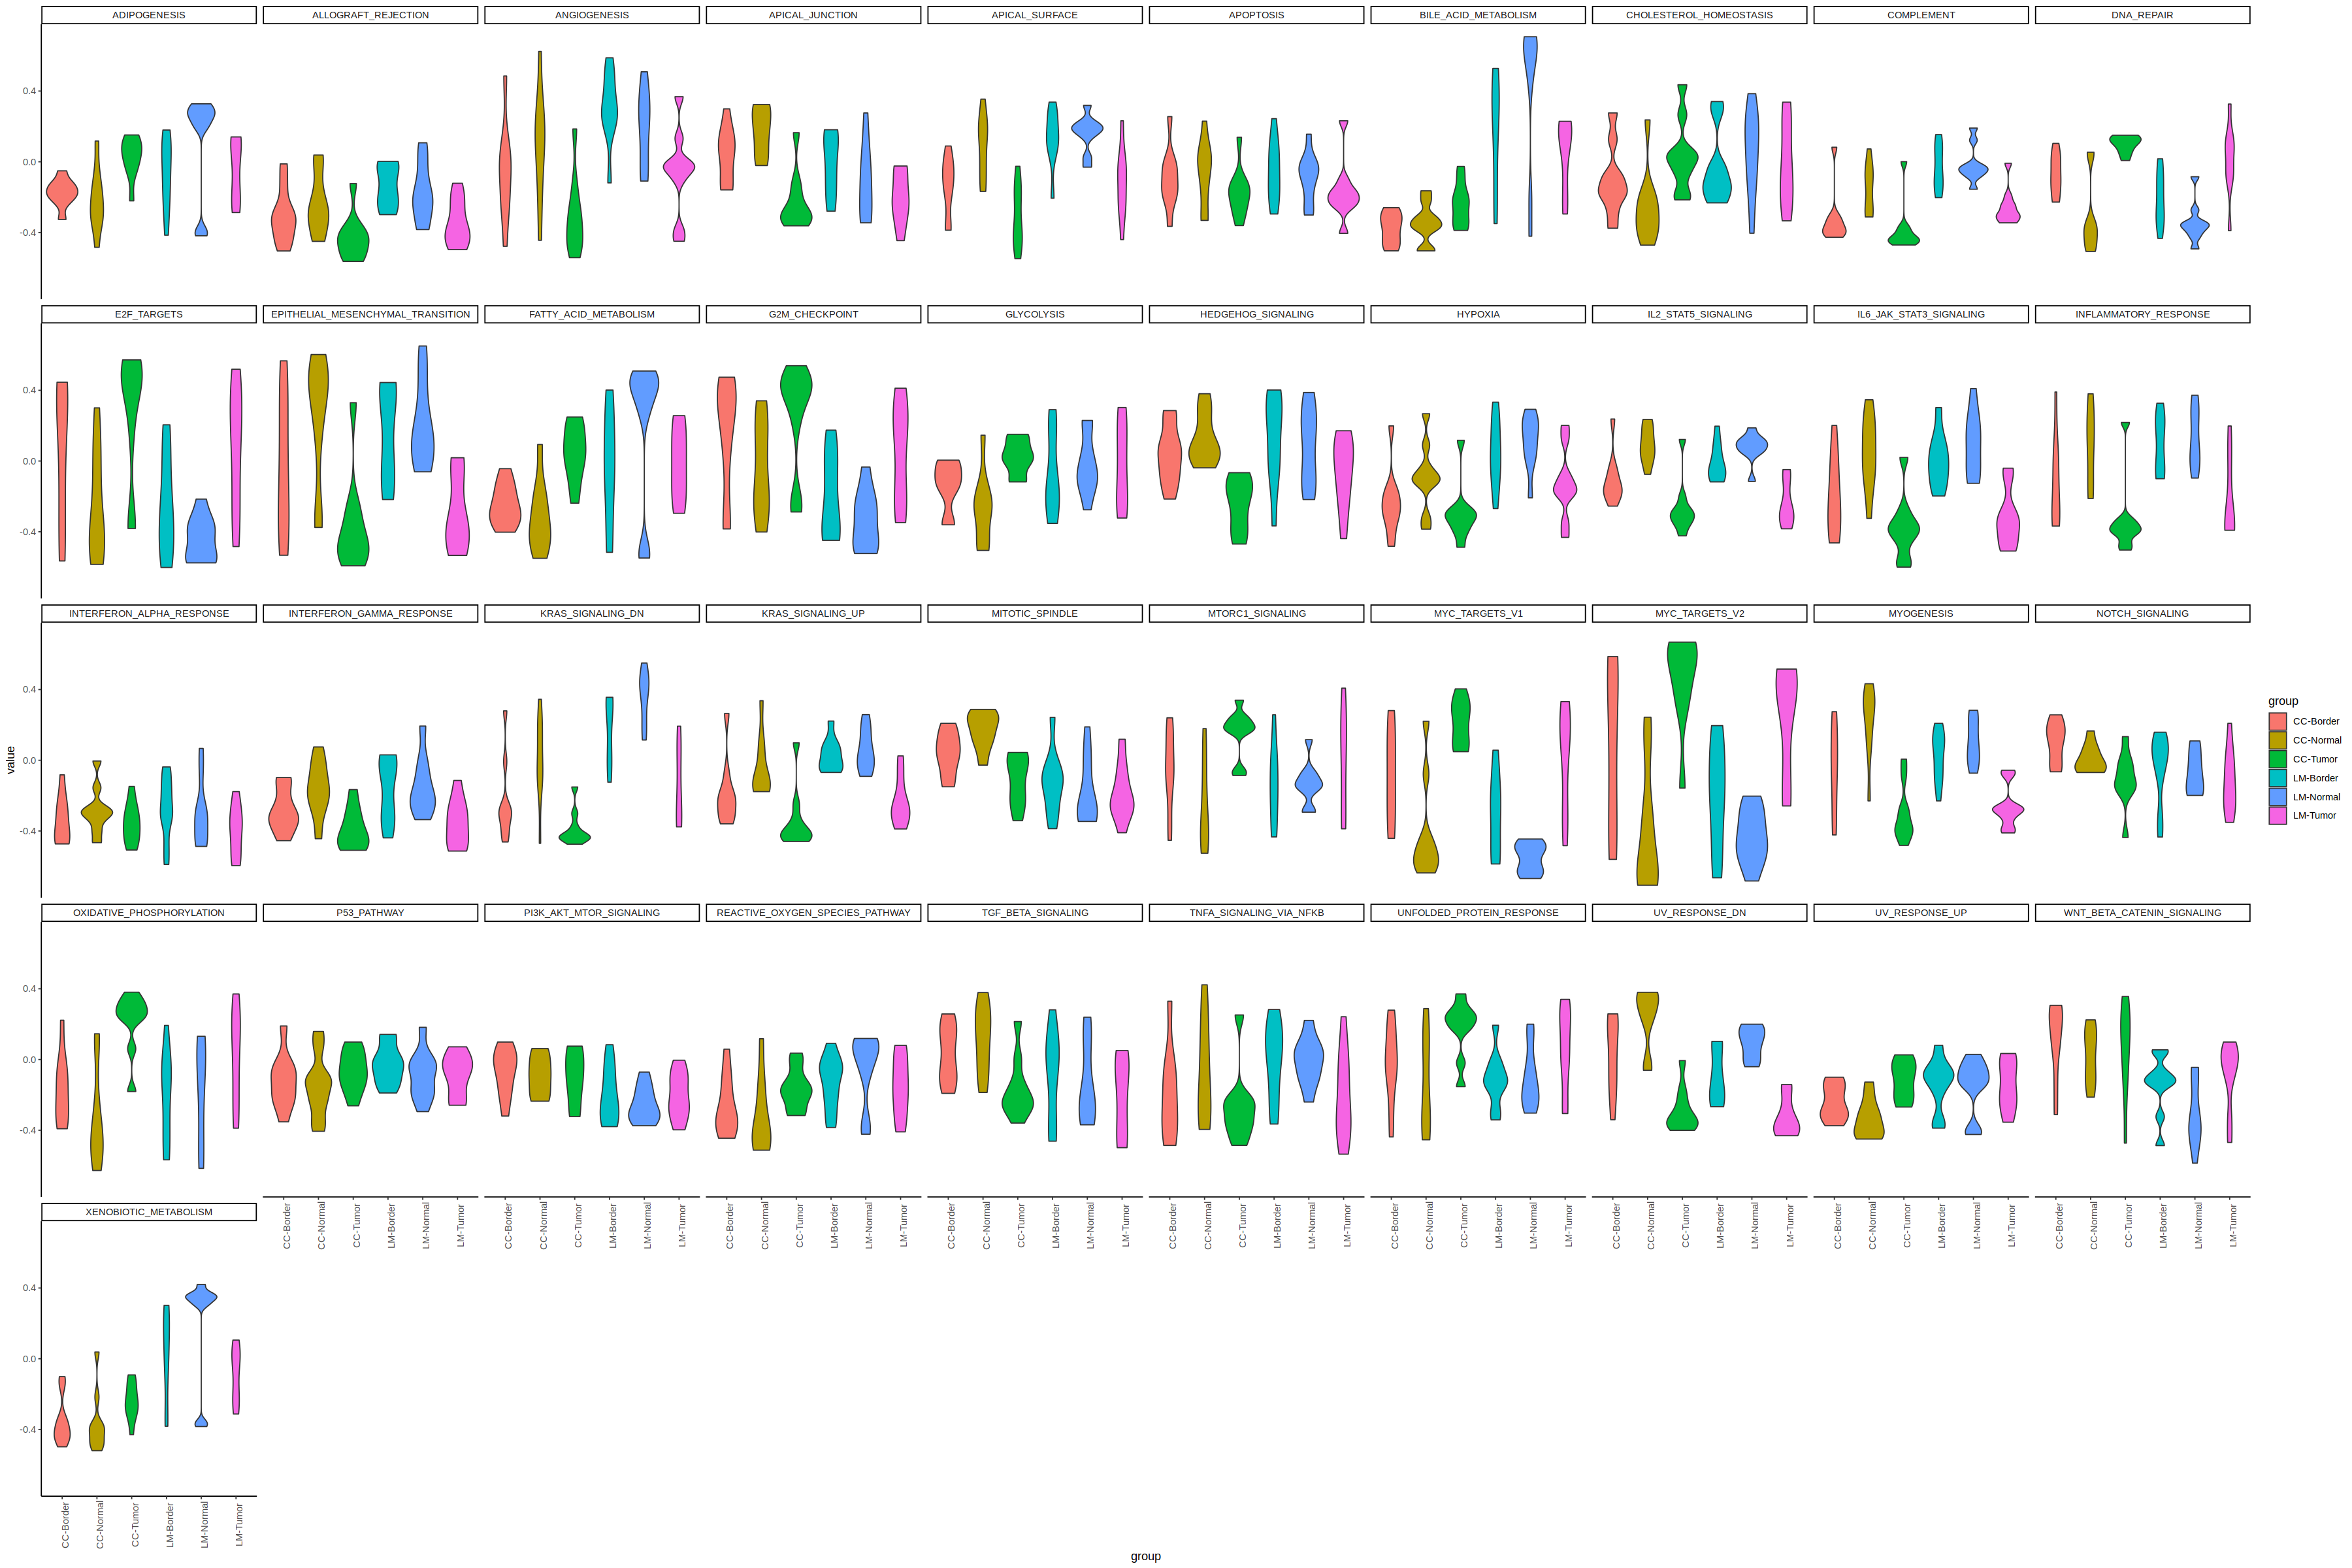

In [206]:
options(repr.plot.width=30,repr.plot.height=20)
ggplot(subset_gsva_p, aes(x=group, y= value, fill=group))+
  theme_classic()+ 
  theme(axis.text.x = element_text(angle = 90))+
  geom_violin() + facet_wrap(.~hallmark,ncol = 10)


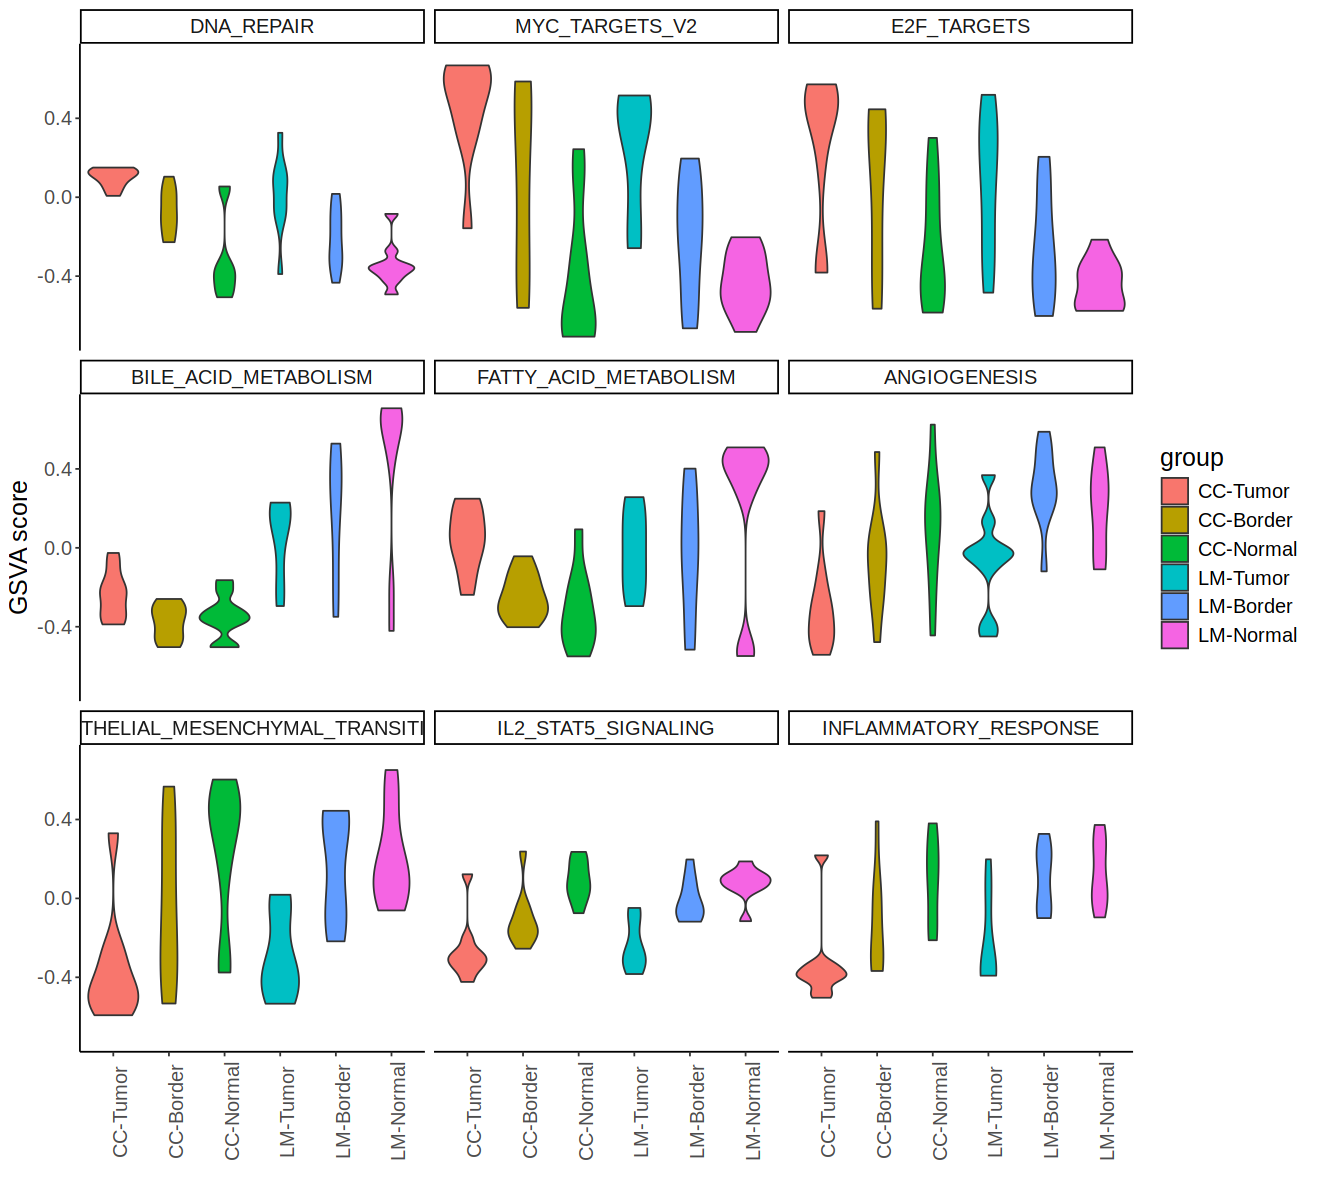

In [249]:
subset_gsva_p <- subset_gsva_p[subset_gsva_p$hallmark %in% c('DNA_REPAIR','MYC_TARGETS_V2','E2F_TARGETS', 'BILE_ACID_METABOLISM','FATTY_ACID_METABOLISM', 
                            'ANGIOGENESIS', 'EPITHELIAL_MESENCHYMAL_TRANSITION','IL2_STAT5_SIGNALING', 'IL6_JAK_STAT3_SIGNALING','INFLAMMATORY_RESPONSE'),]

subset_gsva_p$hallmark <- factor(subset_gsva_p$hallmark, levels = c('DNA_REPAIR','MYC_TARGETS_V2','E2F_TARGETS', 'BILE_ACID_METABOLISM','FATTY_ACID_METABOLISM', 
                            'ANGIOGENESIS', 'EPITHELIAL_MESENCHYMAL_TRANSITION','IL2_STAT5_SIGNALING', 'IL6_JAK_STAT3_SIGNALING','INFLAMMATORY_RESPONSE') )
subset_gsva_p$group <- factor(subset_gsva_p$group, levels = c('CC-Tumor', 'CC-Border', 'CC-Normal', 'LM-Tumor', 'LM-Border', 'LM-Normal' ))

options(repr.plot.width=11,repr.plot.height=10)
ggplot(subset_gsva_p, aes(x=group, y= value, fill=group))+
  theme_classic()+ 
  theme(axis.text.x = element_text(angle = 90),text = element_text(size = 15))+
  xlab('') + ylab('GSVA score') +
  geom_violin() + facet_wrap(.~hallmark,ncol = 3)


# Hallmark celltype

In [2]:
mat <- read.csv('/home/zhaoyp/0.CRLM_ST/res/CellAnno/HallmarkSig/stat.samples.csv',row.names=1)
mat <- mat[!grepl('Others', rownames(mat)), ]

annotation_col = data.frame(
  cell = sapply(rownames(mat), function(x) strsplit(x,'-')[[1]][1]),
  sample = sapply(rownames(mat), function(x) strsplit(x,'-')[[1]][2])
)

LM = mat[grepl("LM", rownames(mat)),]
CC = mat[grepl("CC", rownames(mat)),]


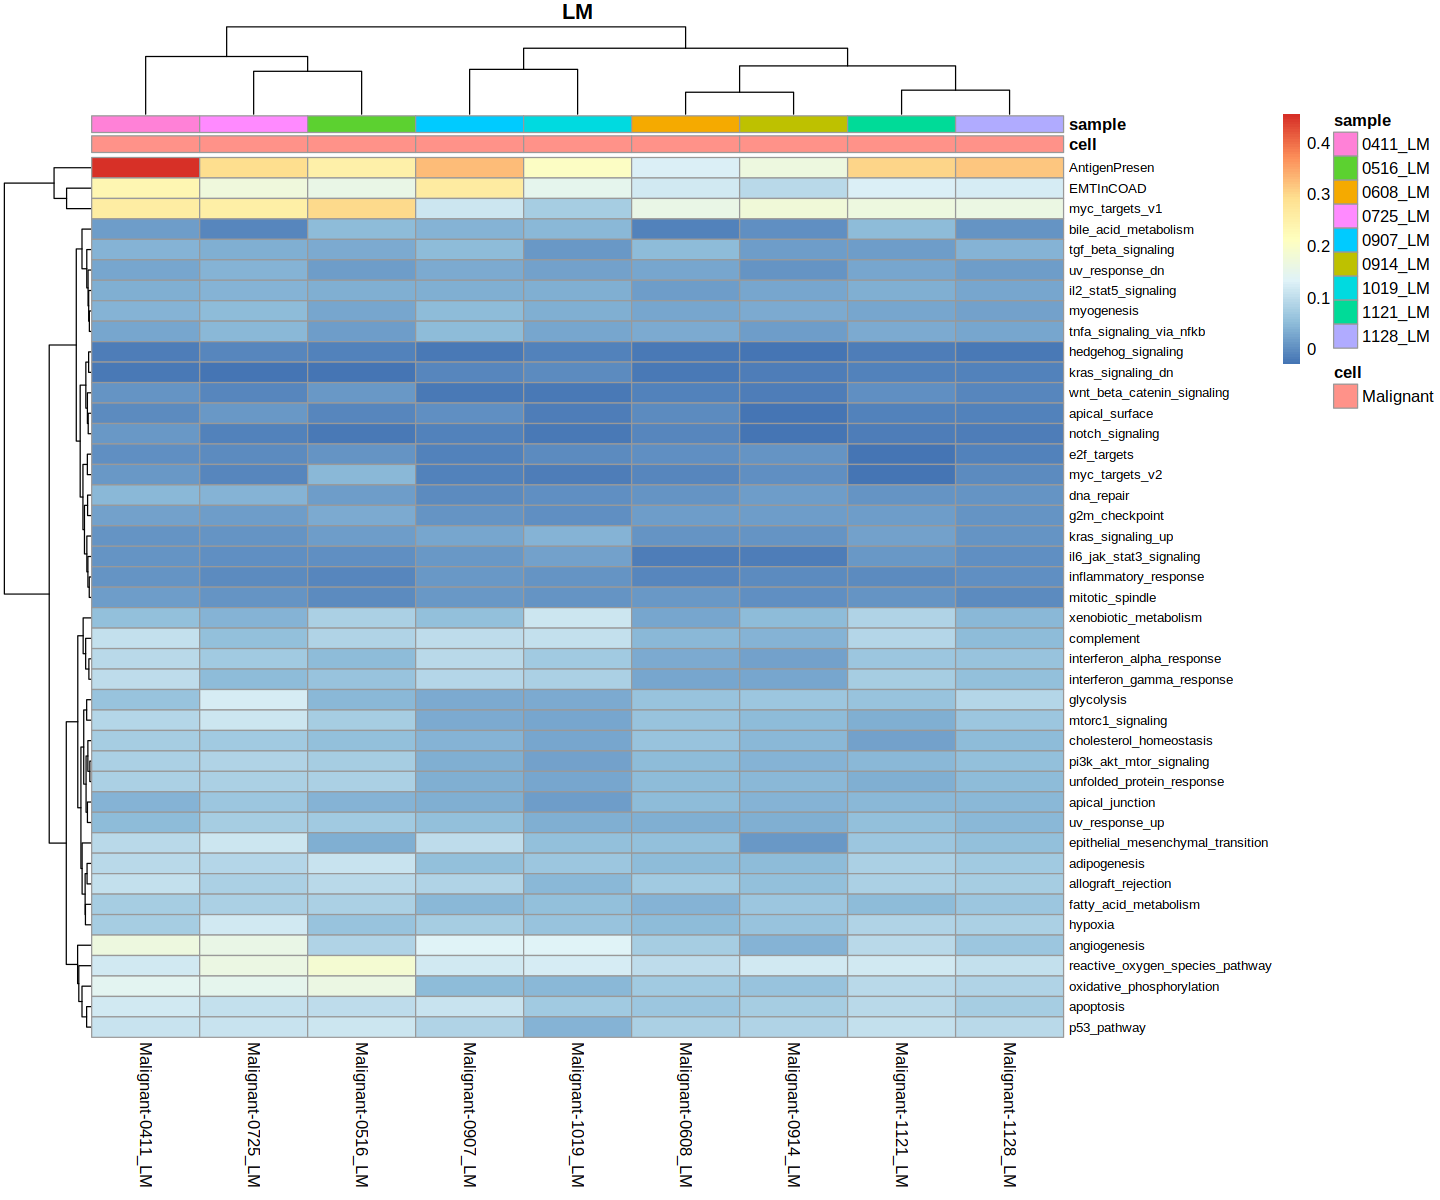

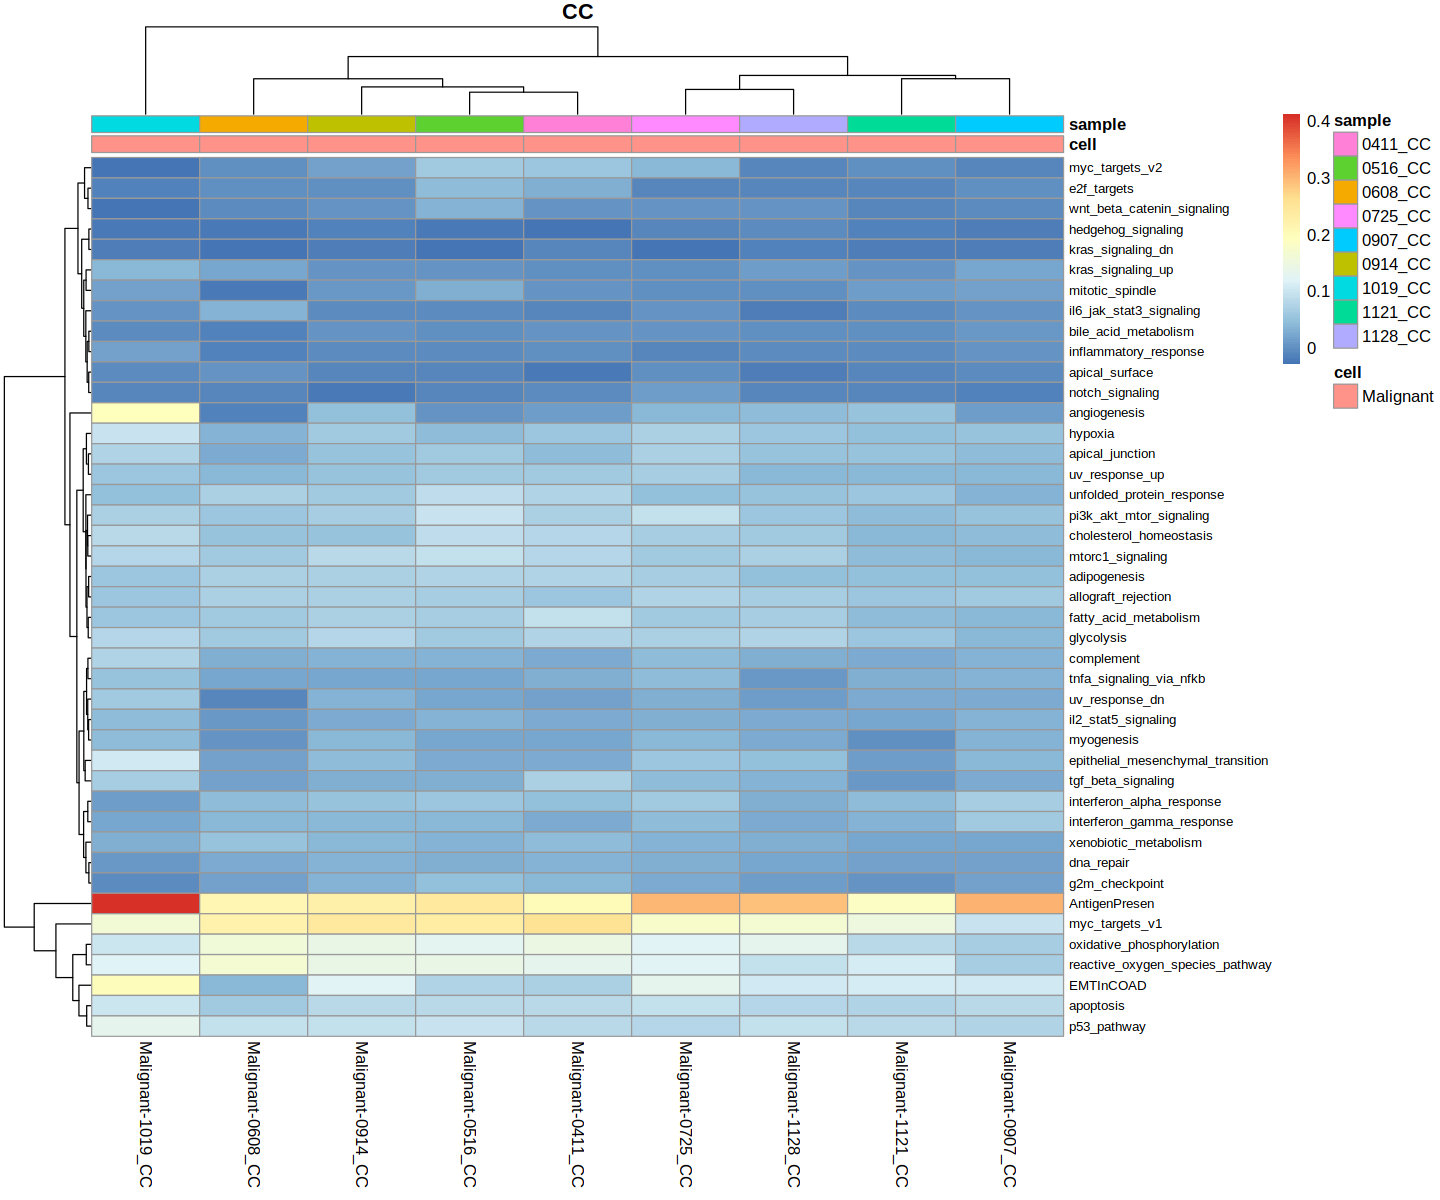

In [3]:

options(repr.plot.width = 12, repr.plot.height = 10) 
mLM = LM[grepl("Malignant", rownames(LM)),]
mCC = CC[grepl("Malignant", rownames(CC)),]
pheatmap(t(mLM), fontsize_row = 8,  annotation_col=annotation_col,main='LM') # scale='row',
pheatmap(t(mCC), fontsize_row = 8, annotation_col=annotation_col,main='CC') # scale='row',


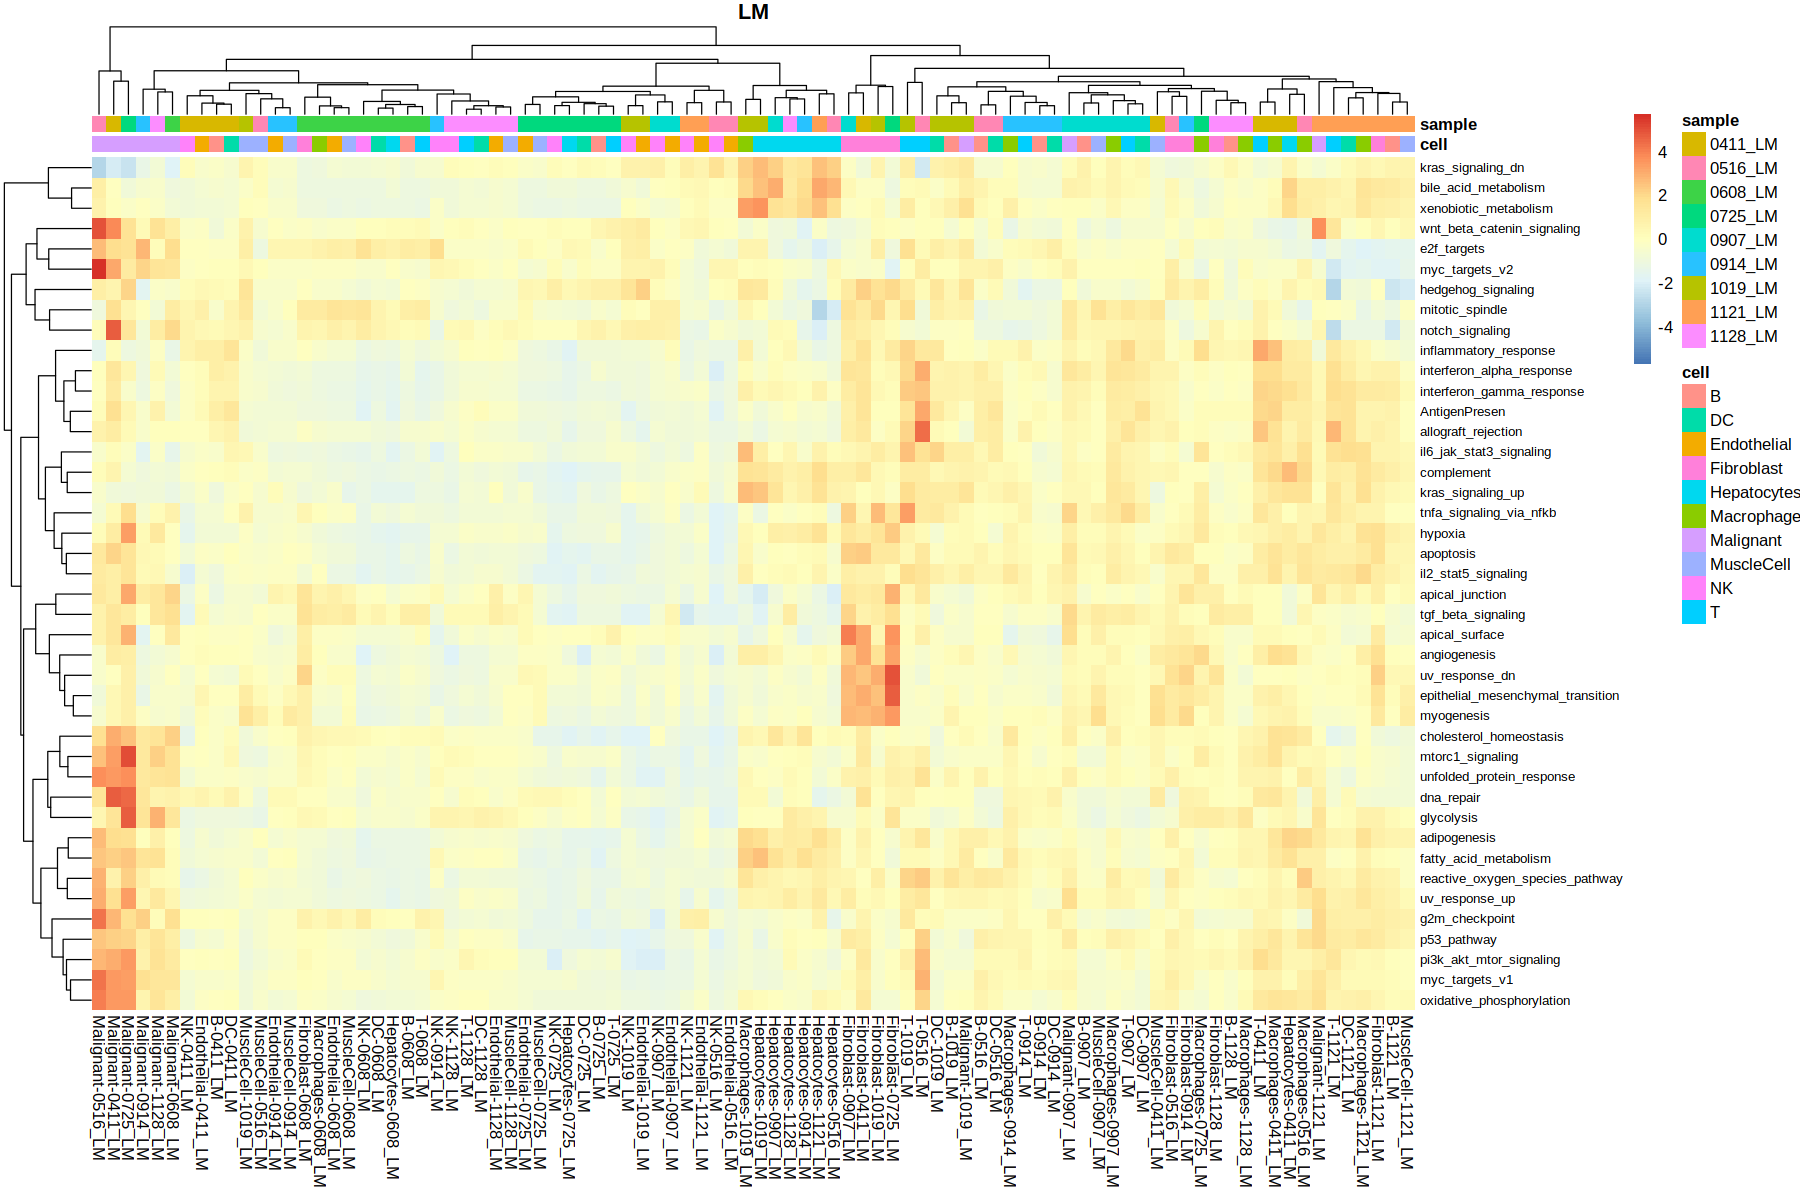

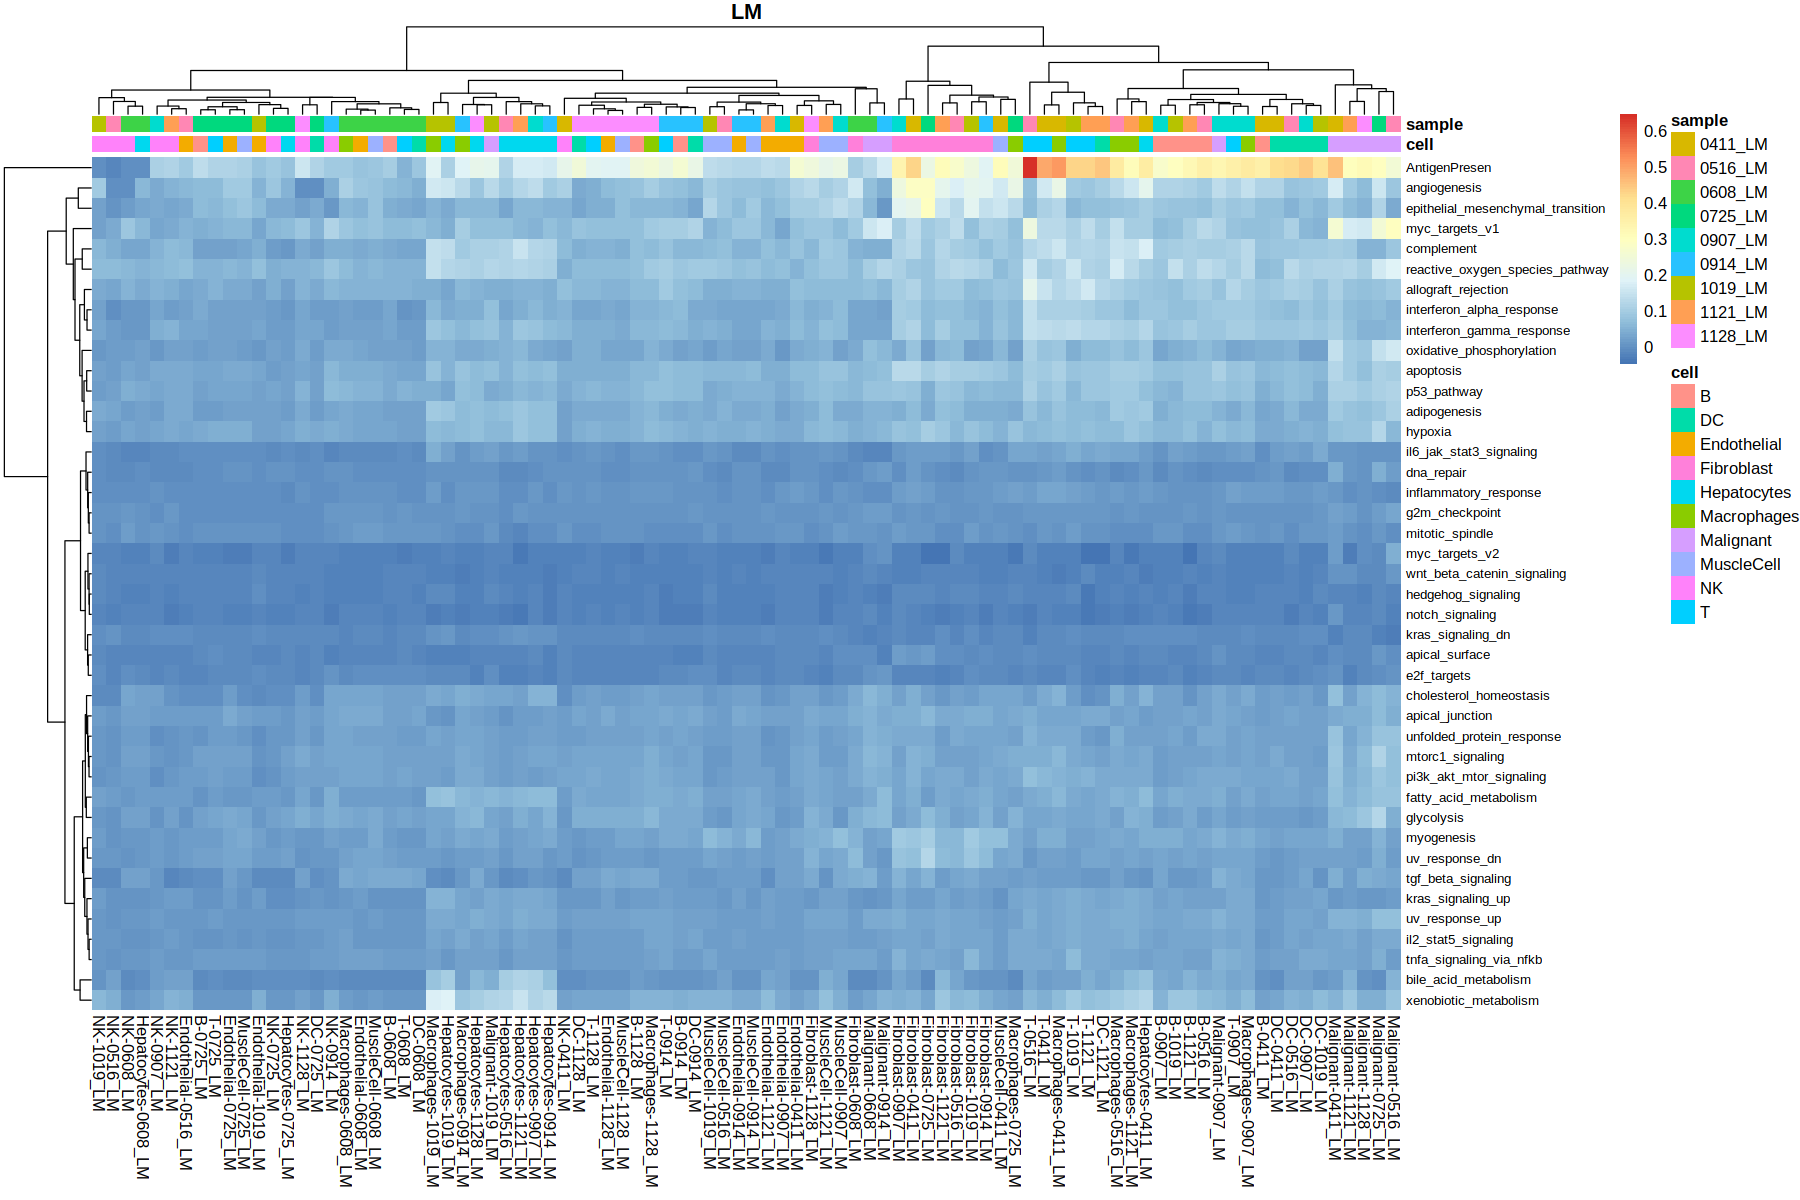

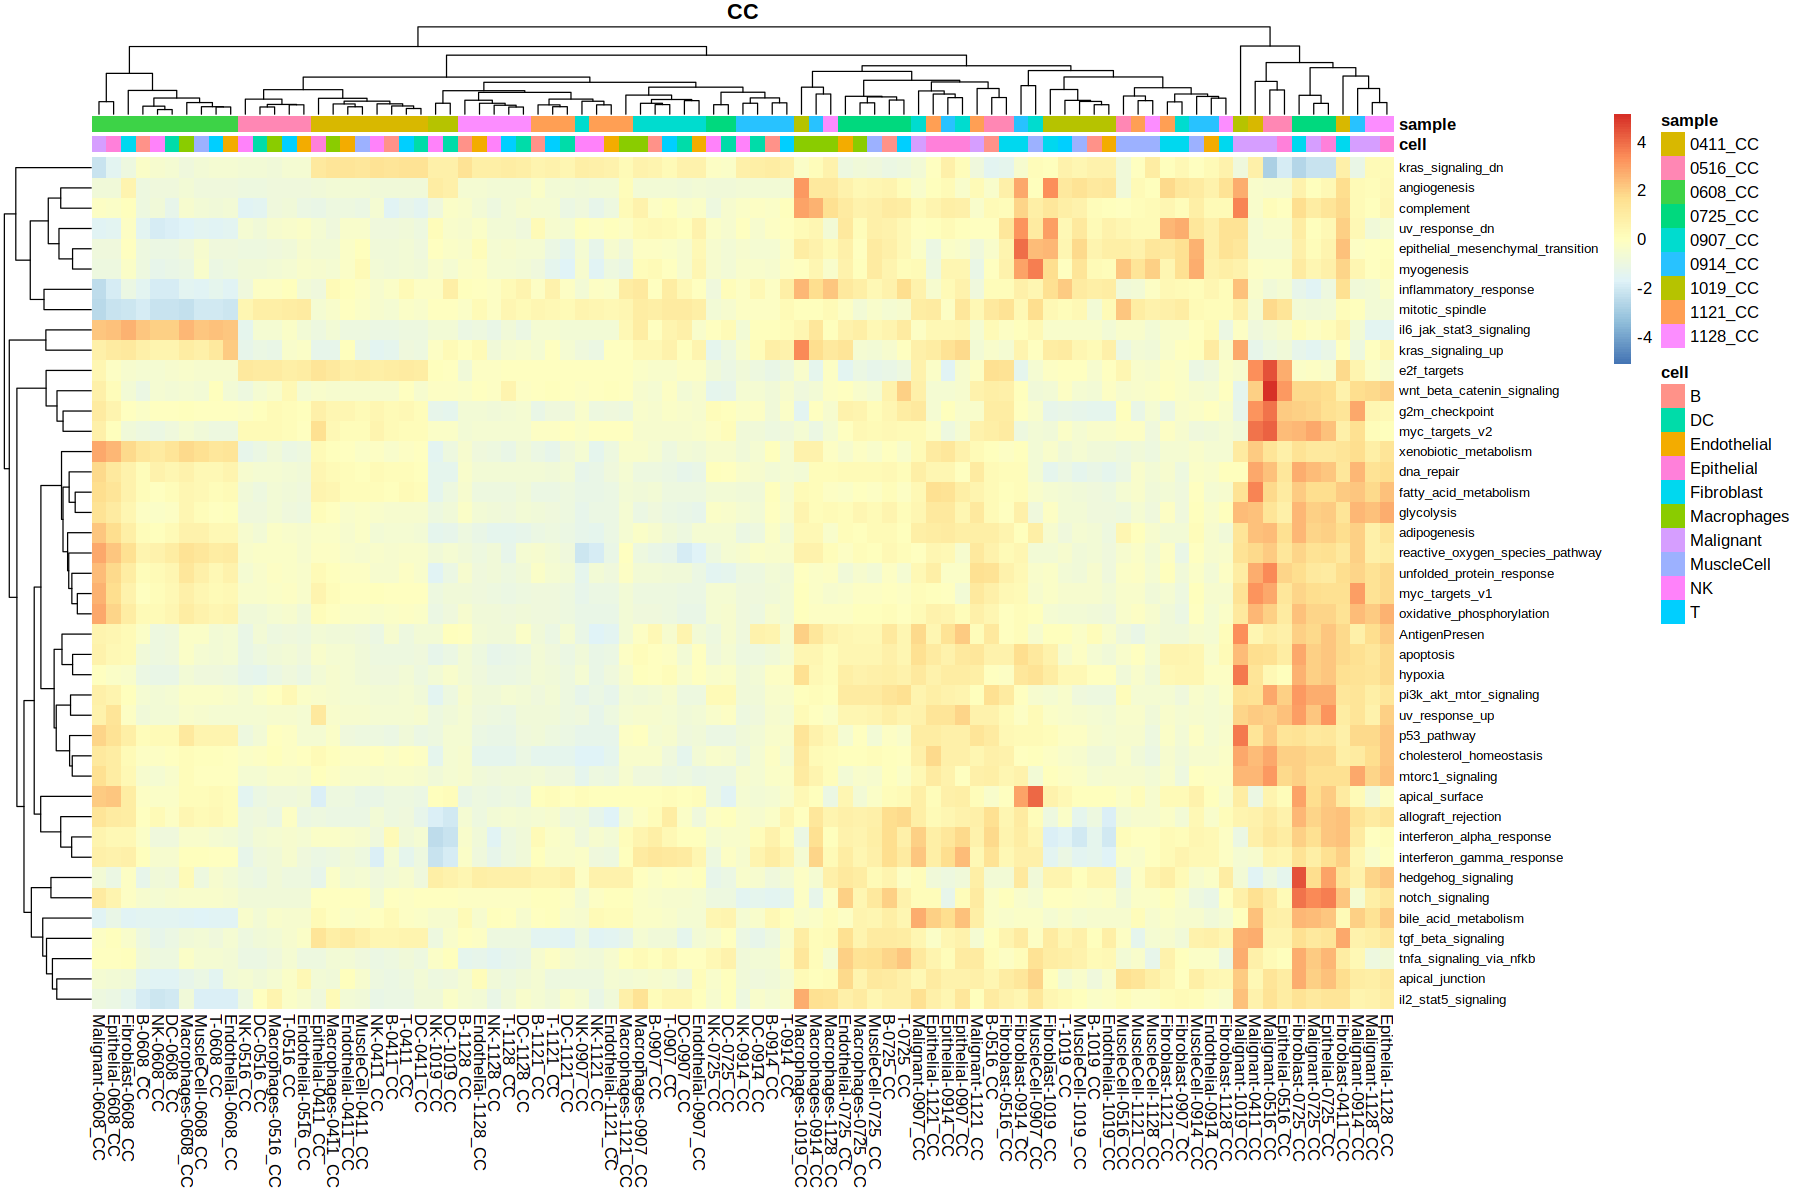

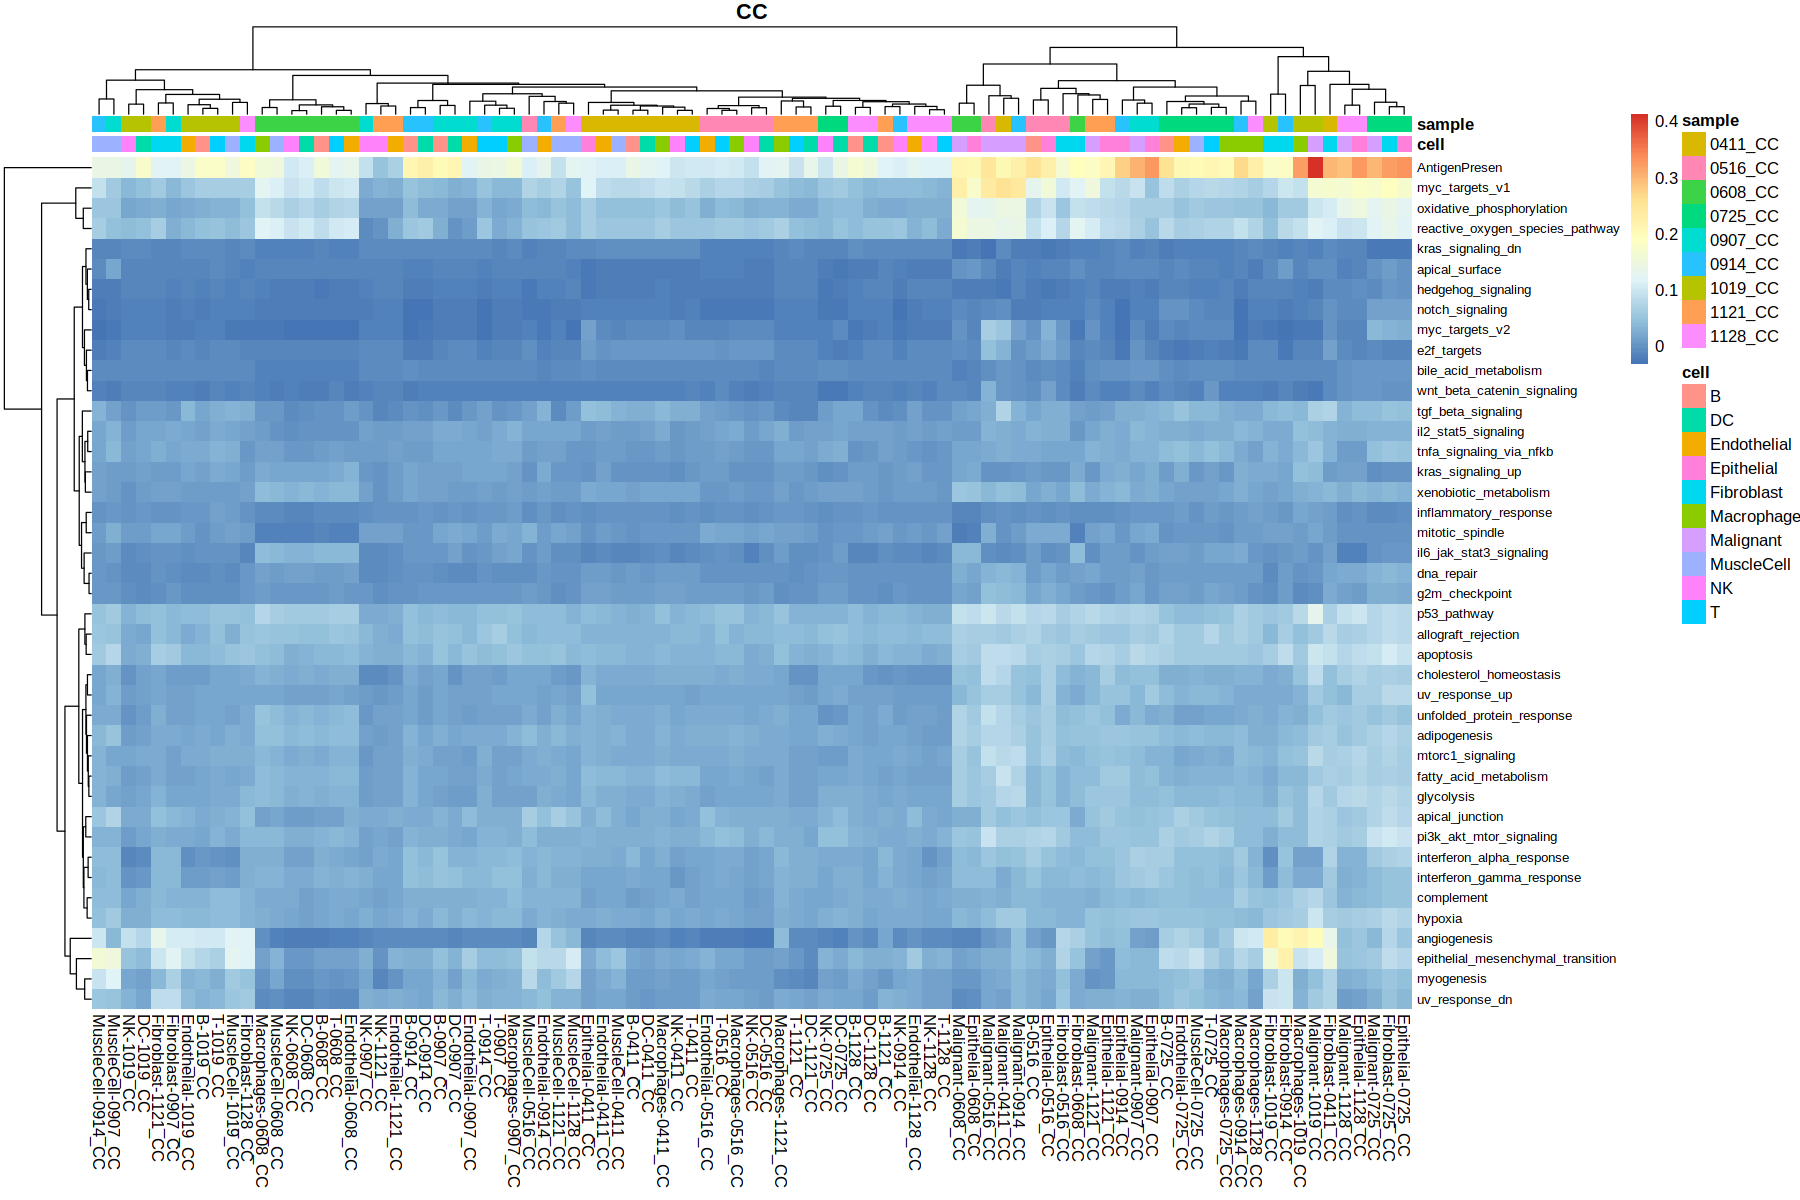

In [4]:
options(repr.plot.width = 15, repr.plot.height = 10) 
pLM = t(LM[,!grepl('EMTInCOAD',colnames(LM))])
pCC = t(CC[,!grepl('EMTInCOAD',colnames(CC))])
pheatmap(pLM, fontsize_row = 8, scale='row', annotation_col=annotation_col,main='LM') # scale='row',
pheatmap(pLM, fontsize_row = 8, annotation_col=annotation_col,main='LM') # scale='row',
pheatmap(pCC, fontsize_row = 8, scale='row', annotation_col=annotation_col,main='CC') # scale='row',
pheatmap(pCC, fontsize_row = 8,  annotation_col=annotation_col,main='CC') # scale='row',


In [10]:
pLM[c('il2_stat5_signaling')]

[1] NA

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 10) 
pLM = t(LM[,!grepl('EMTInCOAD',colnames(LM))])
pCC = t(CC[,!grepl('EMTInCOAD',colnames(CC))])
pheatmap(pLM, fontsize_row = 8, scale='row', annotation_col=annotation_col,main='LM') # scale='row',
pheatmap(pLM, fontsize_row = 8, annotation_col=annotation_col,main='LM') # scale='row',
pheatmap(pCC, fontsize_row = 8, scale='row', annotation_col=annotation_col,main='CC') # scale='row',
pheatmap(pCC, fontsize_row = 8,  annotation_col=annotation_col,main='CC') # scale='row',


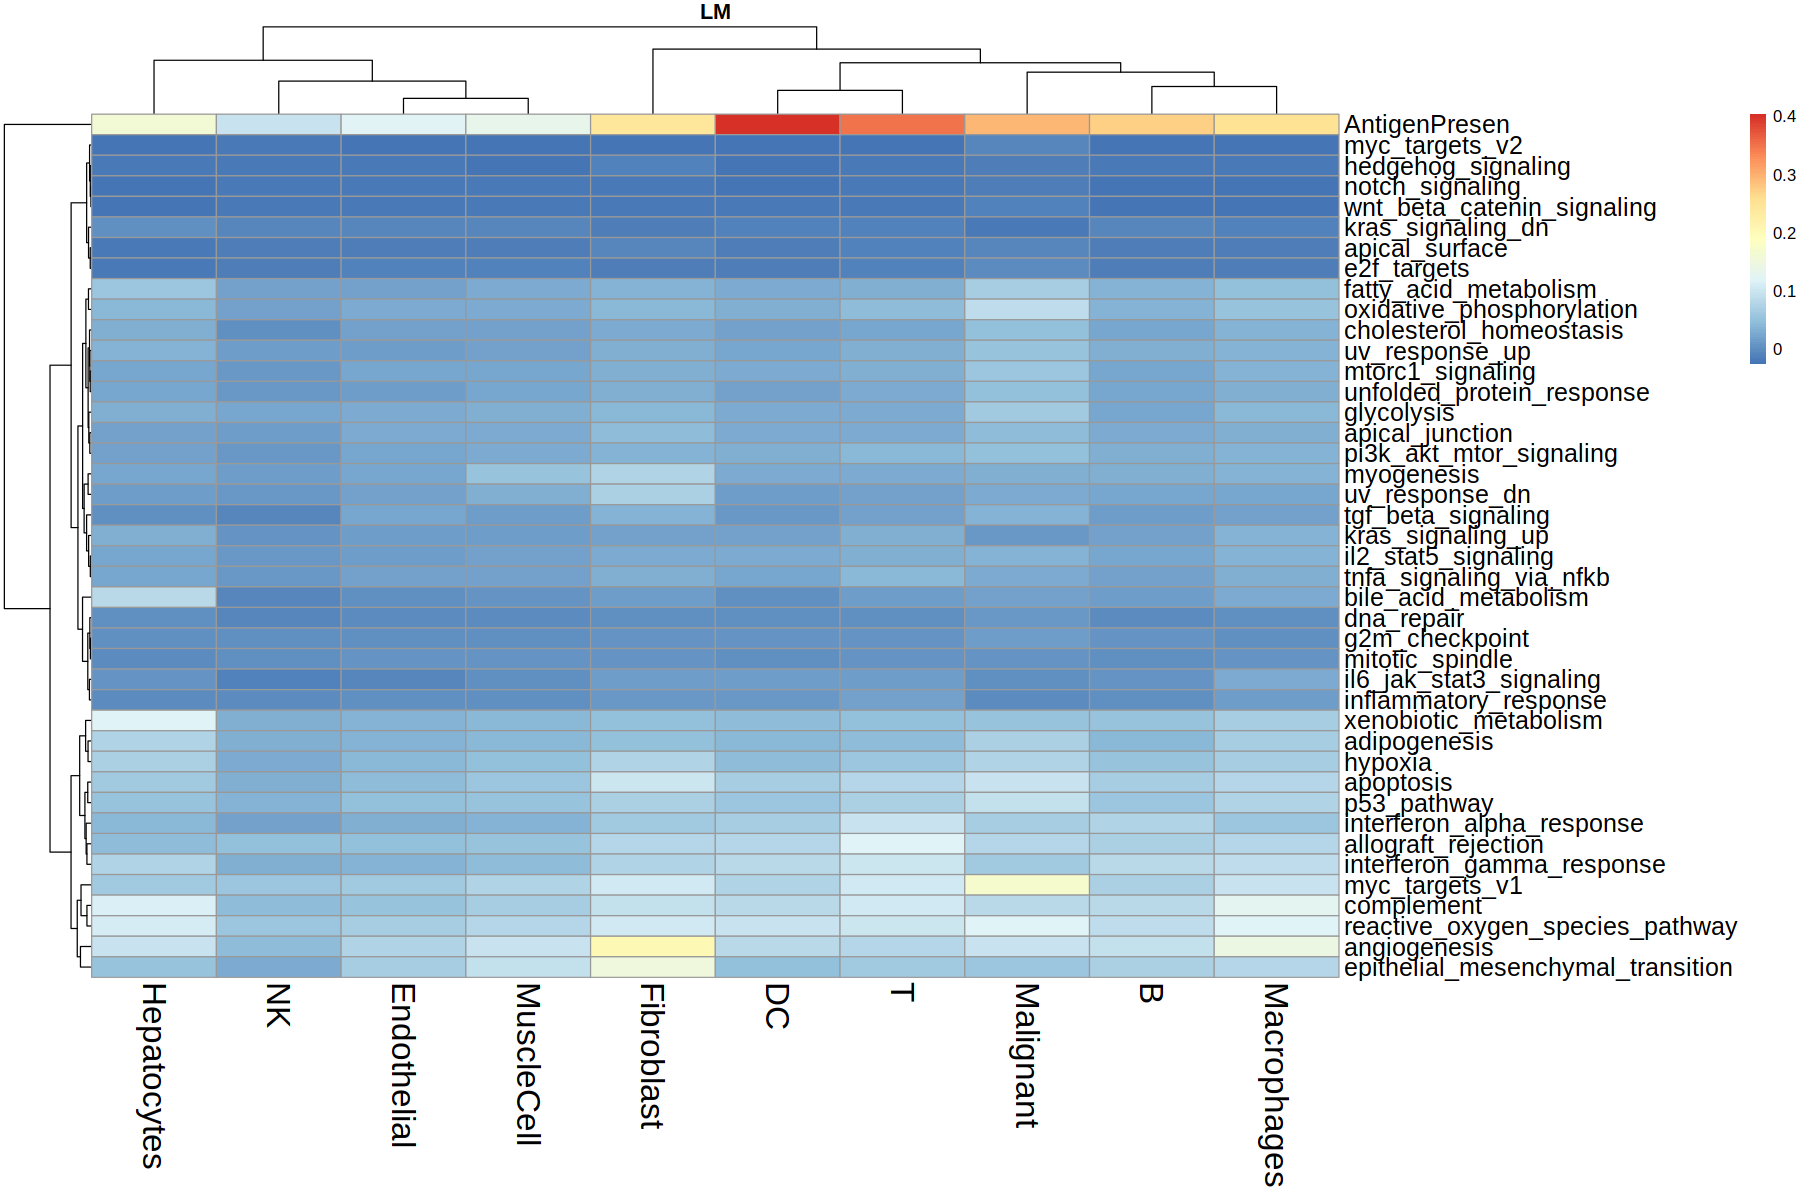

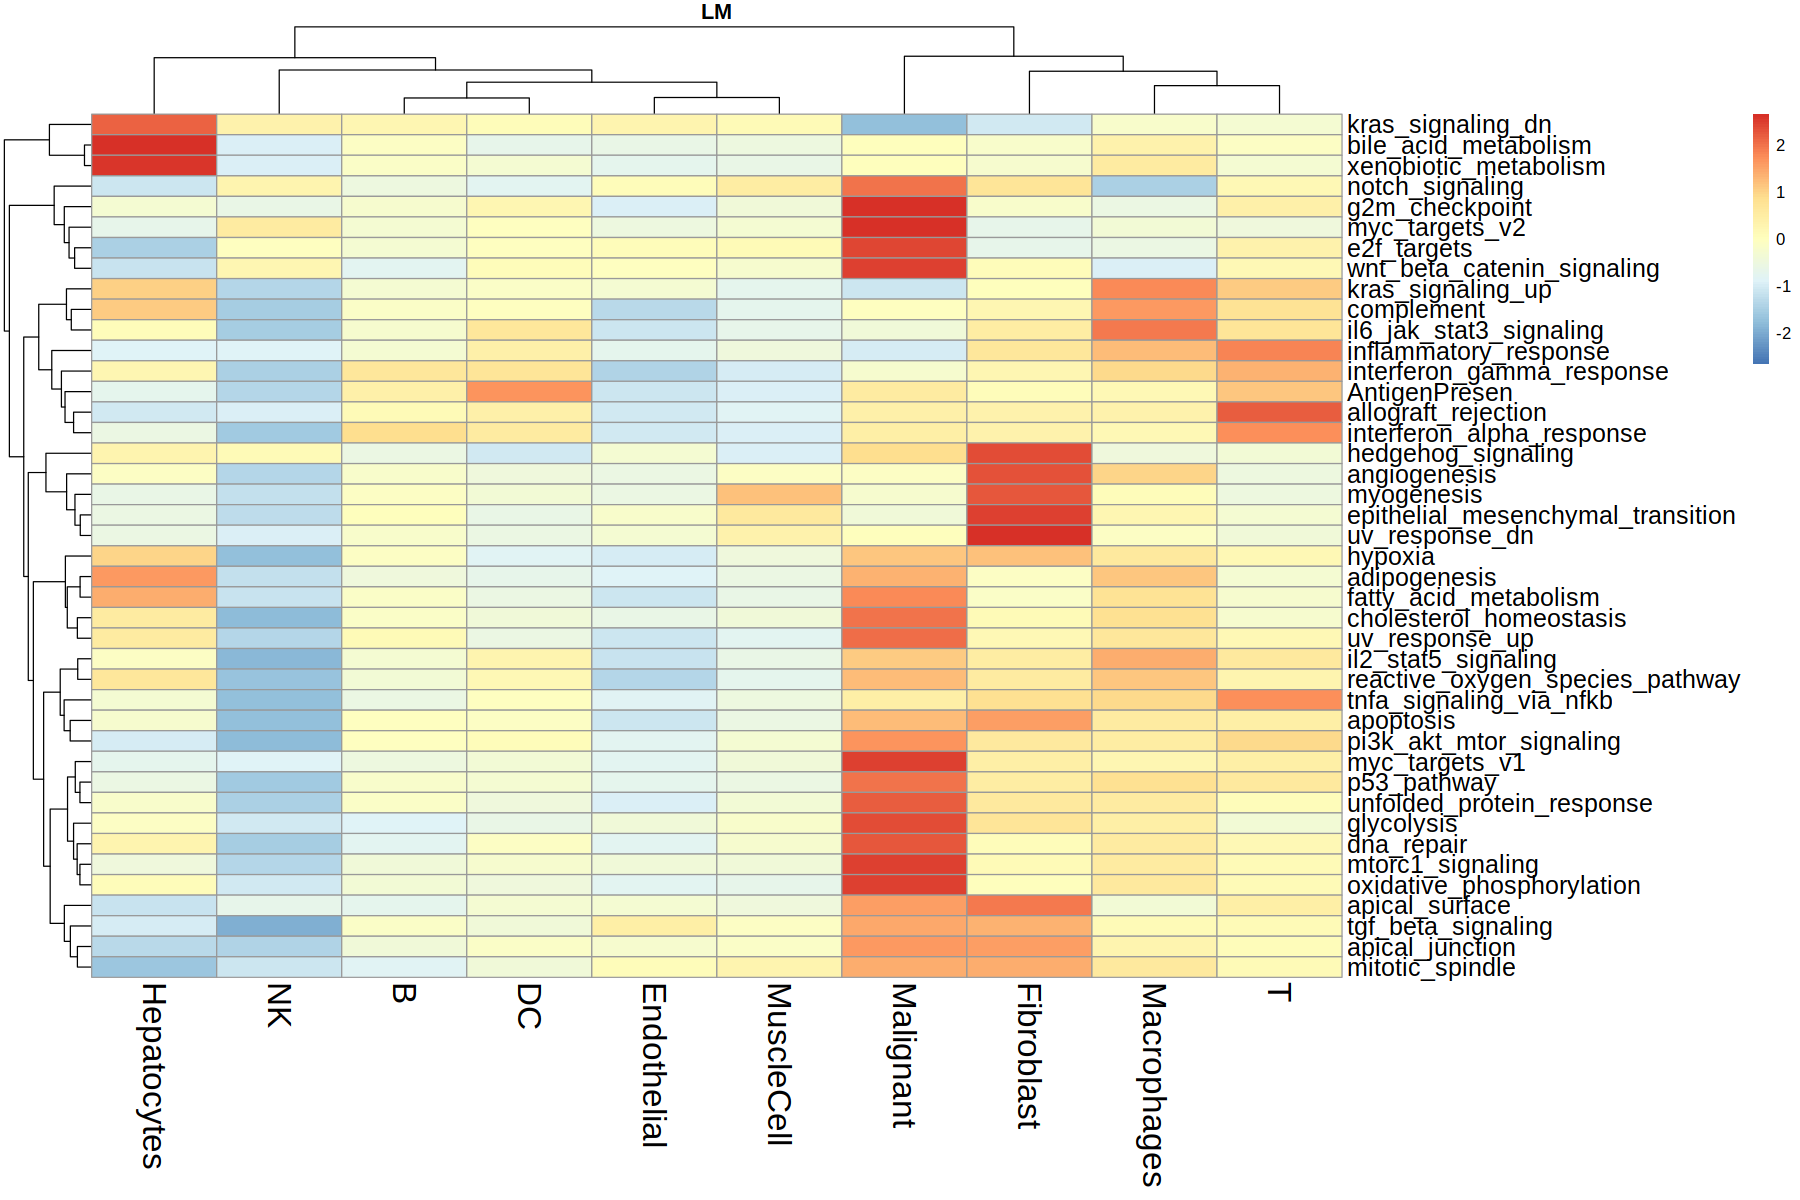

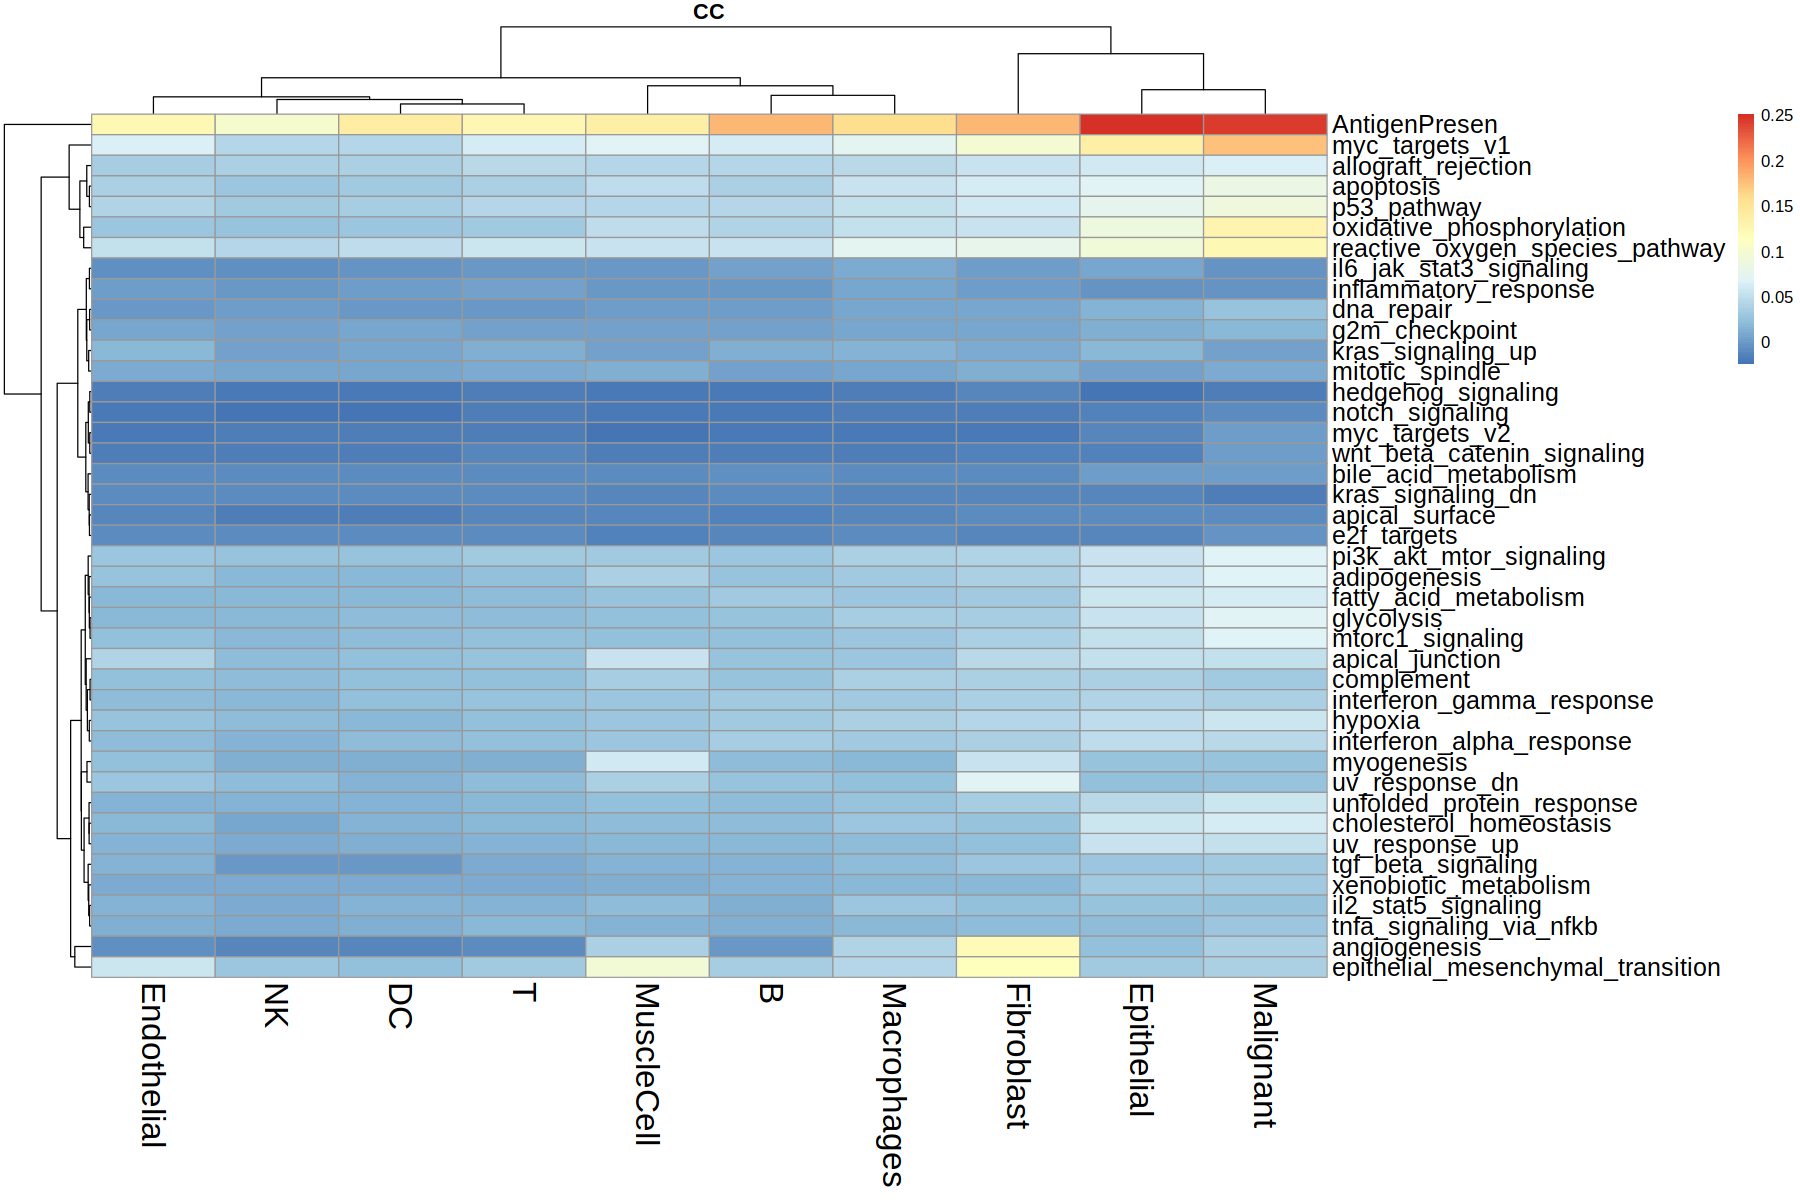

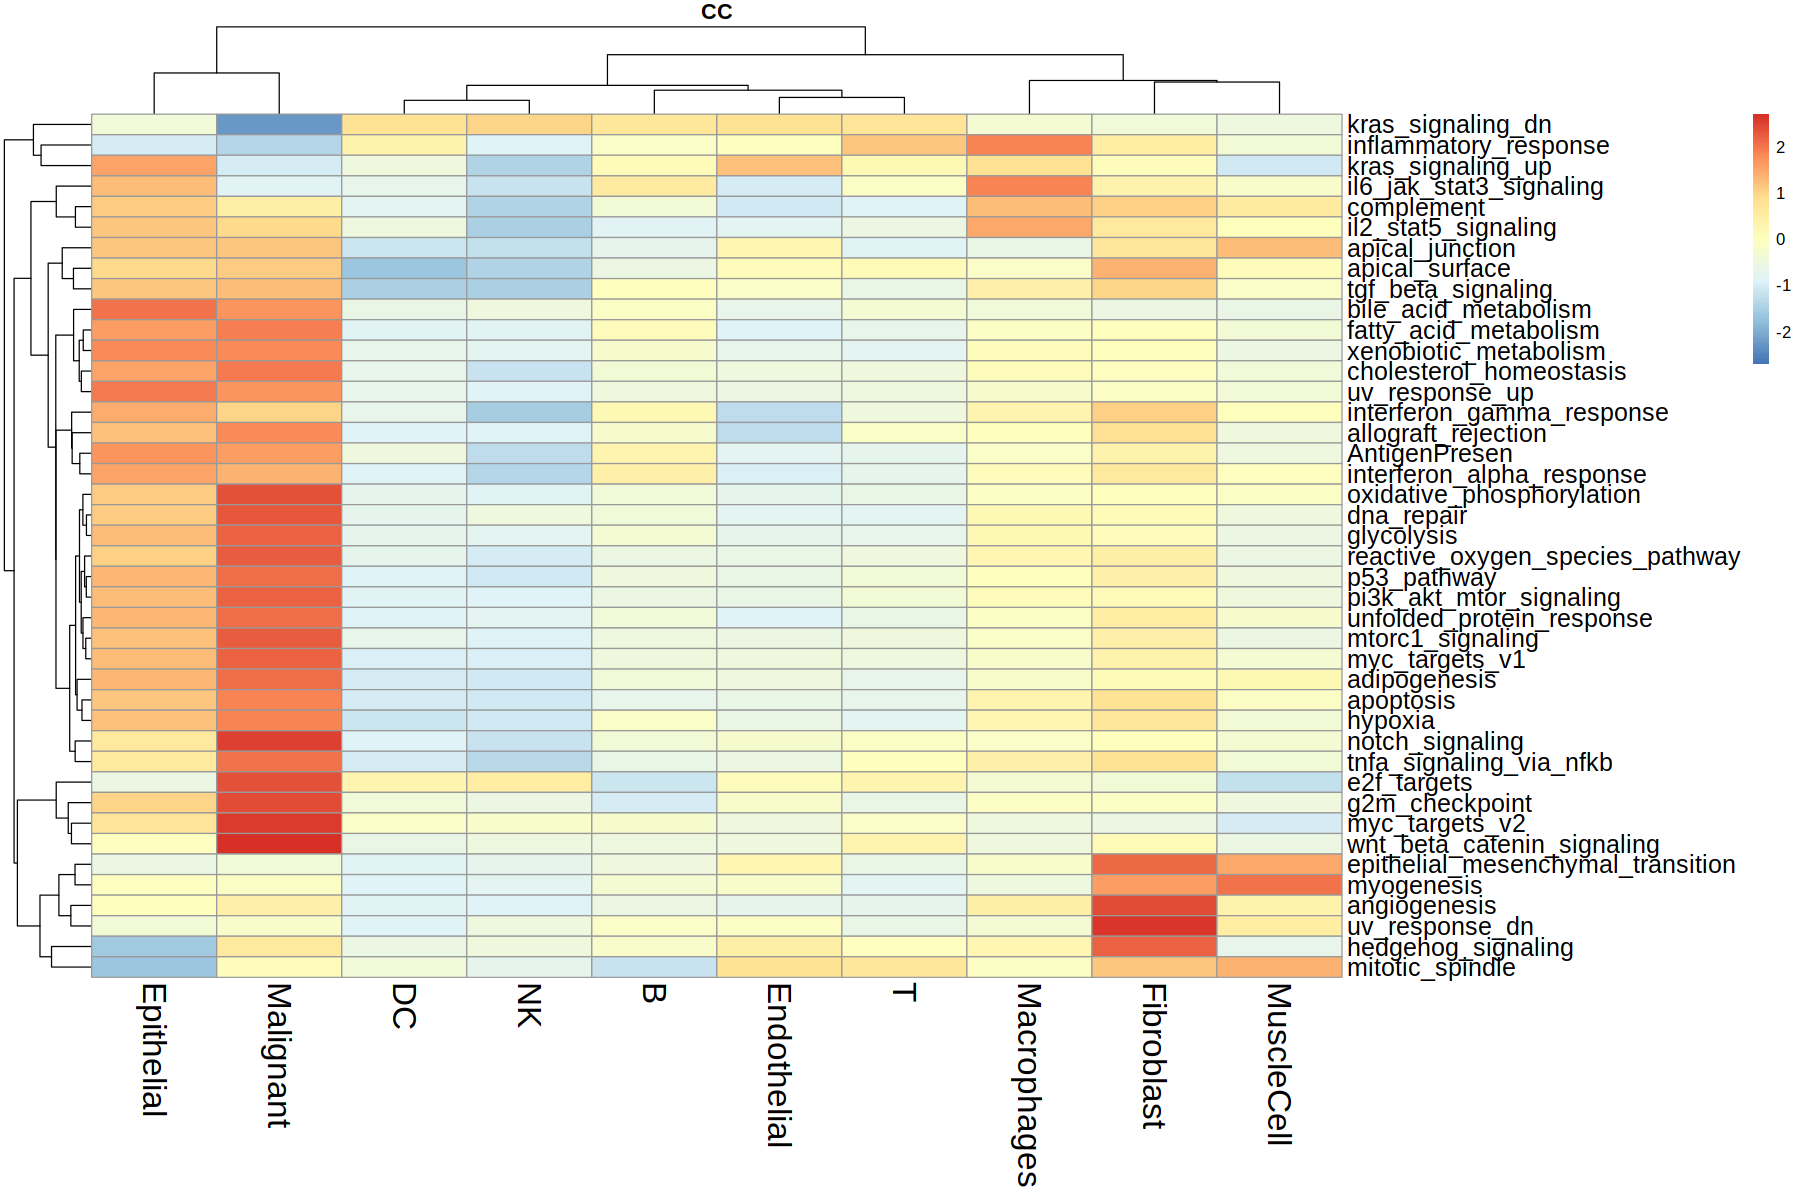

In [23]:
p1LM = t(pLM)
p1LM = as.data.frame(cbind(p1LM,'celltype'=sapply(rownames(p1LM), function(x) strsplit(x,'-')[[1]][1])))
for (i in 1:(dim(p1LM)[2]-1)){
    p1LM[,i] = as.numeric(p1LM[,i] )
}
p1LM = p1LM %>% group_by(celltype) %>% summarize_all(median) %>% column_to_rownames('celltype')
pheatmap(t(p1LM), fontsize_col=20, fontsize_row=15, main='LM') # scale='row',scale='row', 
pheatmap(t(p1LM), fontsize_col=20, fontsize_row=15, scale='row',  main='LM') # scale='row',scale='row', 


p1CC = t(pCC)
p1CC = as.data.frame(cbind(p1CC,'celltype'=sapply(rownames(p1CC), function(x) strsplit(x,'-')[[1]][1])))
for (i in 1:(dim(p1CC)[2]-1)){
    p1CC[,i] = as.numeric(p1CC[,i] )
}
p1CC = p1CC %>% group_by(celltype) %>% summarize_all(median) %>% column_to_rownames('celltype')
pheatmap(t(p1CC), fontsize_col=20, fontsize_row=15, main='CC') # scale='row',scale='row', 
pheatmap(t(p1CC), fontsize_col=20, fontsize_row=15, scale='row',  main='CC') # scale='row',scale='row', 

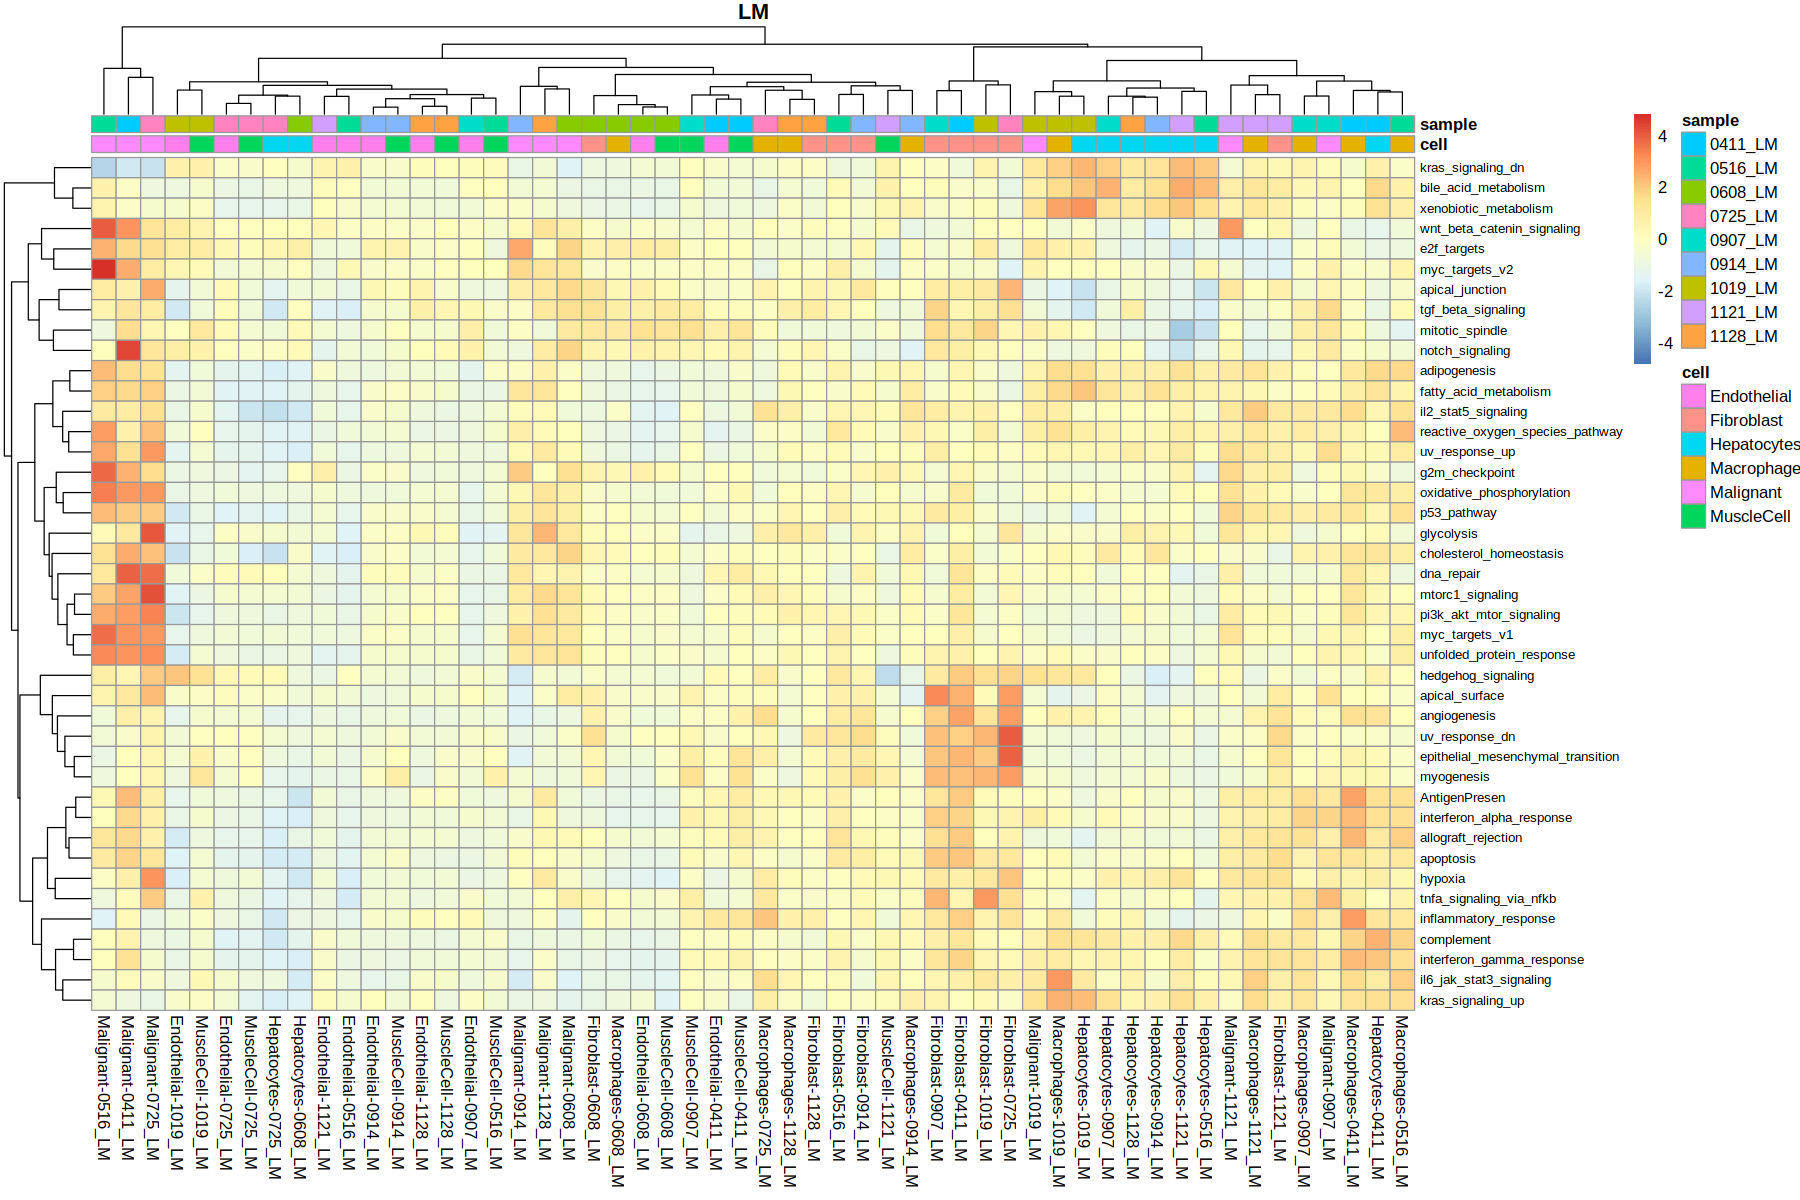

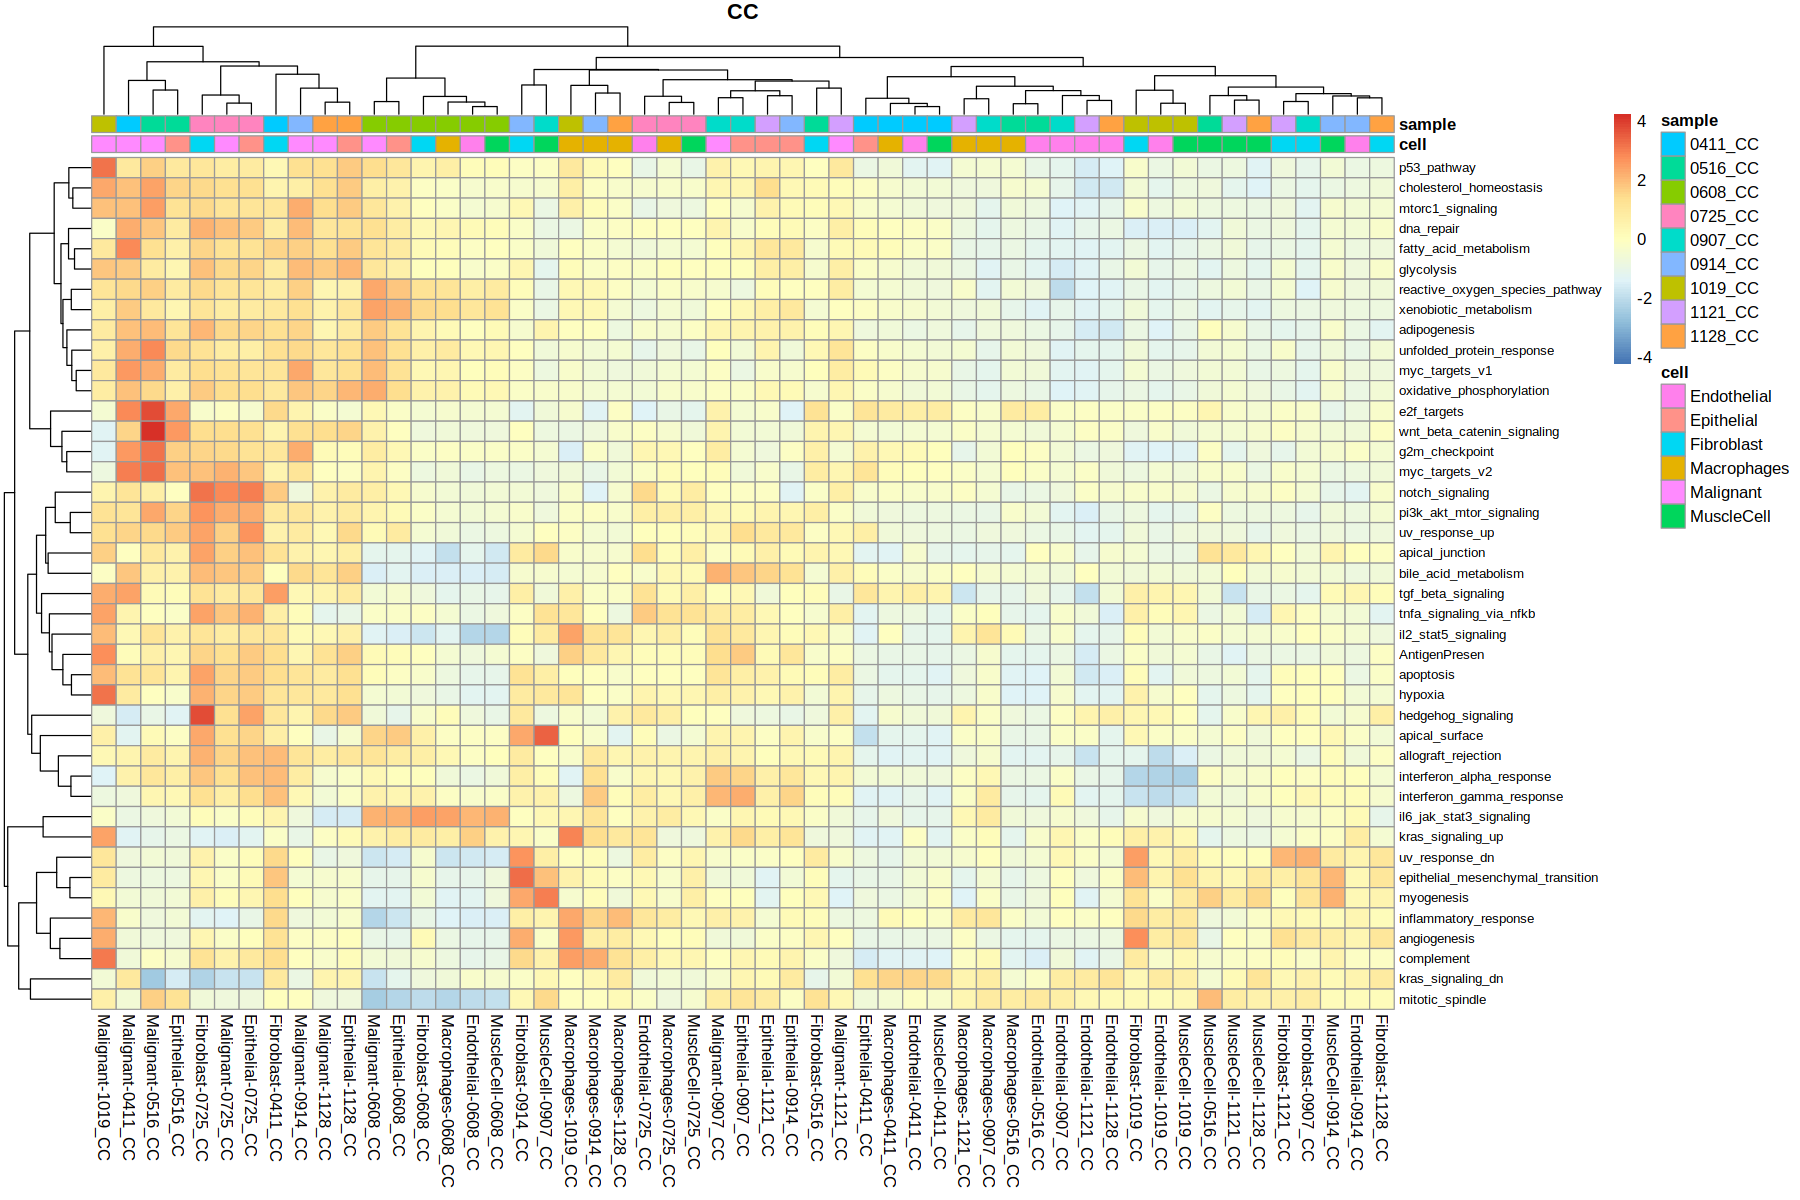

In [10]:
main_LM = LM[!grepl("T|NK|B|DC", rownames(LM)),]
main_CC = CC[!grepl("T|NK|B|DC", rownames(CC)),]
main_LM = main_LM[,!grepl('EMTInCOAD',colnames(main_LM))]
main_CC = main_CC[,!grepl('EMTInCOAD',colnames(main_CC))]

options(repr.plot.width = 15, repr.plot.height = 10) 
pheatmap(t(main_LM), fontsize_row = 8,  scale='row', annotation_col=annotation_col,main='LM') #
pheatmap(t(main_CC), fontsize_row = 8, scale='row', annotation_col=annotation_col,main='CC') # 
